    For SMOTENC to work properly:
        check if there are ordinal or nominal categoricals and that there is numeric features
        if there is categoricals (ordinal or nominal) then we go with SMOTENC, only categoricals go with SMOTEN, and numericals only goes into the numeric criteria for SMOTE or user defined option

        If both categorical and numerical features in dataset then treat both ordinal and nominal features as ordinal beforehand ordinal encoding on all categoricals (nominal and ordinal) prior to SMOTENC (if ordinal or nominal categorical features available)
        Before SMOTENC: Only apply Ordinal Encoding to categorical features.
        Apply SMOTENC on the ordinal-encoded training data only
        After SMOTENC: Apply One-Hot Encoding to the resampled dataset.

    For easy inverse transform:
        After SMOTENC, apply one-hot encoding on your training set (already resampled) to provide the training datasets
        Then save the encoders/transformers/scalars/feature order needed
        Reload encoders/transformers/scalars/feature order
        Use the reloaded encoders/transformers/scalars/feature order your untouched test dataset (ordinal-encoded but not resampled).
        Inverse transform by undoing the one hot encoding, then ordinal encoding
        Reload encoders/transformers/scalars/feature order for predict mode
        Use the reloaded encoders/transformers/scalars/feature order your untouched predict dataset (ordinal-encoded but not resampled).
        Inverse transform by undoing the one hot encoding, then ordinal encoding

Hence, the code snippet you shared does exactly that:

    Ordinal → SMOTENC → One-Hot → Model.
    To invert, do the steps in reverse: One-Hot → Ordinal.

Reverse Transformation Order for Outputs:

    Step 1: Undo one-hot encoding → get ordinal integers.
    Step 2: Undo ordinal encoding → get original categories.

In [1]:
# feature_manager.py

import logging
import pandas as pd
import pickle
from typing import Optional, List, Dict, Any, Tuple
import os
import sys

# Configure logging
logging.basicConfig(
    level=logging.INFO,  # Set to DEBUG for more verbose output
    format='%(asctime)s [%(levelname)s] %(name)s: %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger('feature_manager')


class FeatureManager:
    def __init__(self, save_path: str = 'features_metadata.pkl'):
        self.save_path = save_path
    
    def save_features(
        self,
        features_df: pd.DataFrame,
        ordinal_categoricals: Optional[List[str]],
        nominal_categoricals: Optional[List[str]],
        numericals: Optional[List[str]],
        y_variable: List[str],
        dataset_csv_path: str
    ) -> None:
        """
        Save selected features and their metadata to a pickle file.
        """
        try:
            if features_df.empty:
                raise ValueError("features_df is empty. Cannot save empty features.")
            if not os.path.exists(dataset_csv_path):
                raise FileNotFoundError(f"Dataset CSV file does not exist at path: {dataset_csv_path}")
            
            # Prepare metadata
            data_to_save = {
                'features': features_df.columns.tolist(),
                'ordinal_categoricals': ordinal_categoricals or [],
                'nominal_categoricals': nominal_categoricals or [],
                'numericals': numericals or [],
                'y_variable': y_variable,
                'dataset_csv_path': dataset_csv_path
            }
            
            # Ensure the directory exists
            os.makedirs(os.path.dirname(self.save_path), exist_ok=True)
            
            # Save metadata to pickle
            with open(self.save_path, 'wb') as f:
                pickle.dump(data_to_save, f)
            logger.info(f"✅ Features and metadata saved to {self.save_path}")
            
        except Exception as e:
            logger.error(f"❌ Failed to save features and metadata: {e}")
            raise  # Re-raise exception after logging
    
    def load_features_and_dataset(
        self,
        debug: bool = False
    ) -> Tuple[pd.DataFrame, Dict[str, List[str]]]:
        """
        Load features and metadata from a pickle file, then load and filter the original dataset based on the loaded features.
        """
        try:
            if not os.path.exists(self.save_path):
                raise FileNotFoundError(f"The file {self.save_path} does not exist.")
            
            # Load metadata from pickle
            with open(self.save_path, 'rb') as f:
                loaded_data = pickle.load(f)
            logger.info(f"✅ Features and metadata loaded from {self.save_path}")
            
            # Extract metadata
            selected_features = loaded_data.get('features', [])
            ordinal_categoricals = loaded_data.get('ordinal_categoricals', [])
            nominal_categoricals = loaded_data.get('nominal_categoricals', [])
            numericals = loaded_data.get('numericals', [])
            y_variable = loaded_data.get('y_variable', [])
            dataset_path = loaded_data.get('dataset_csv_path', '')
            
            logger.debug(f"Dataset Path Retrieved: {dataset_path}")
            logger.debug(f"Number of Features Selected: {len(selected_features)}")
            logger.debug(f"Features Selected: {selected_features}")
            
            # Validate dataset_path
            if not dataset_path:
                logger.error("Dataset path is empty in the loaded metadata.")
                raise ValueError("Dataset path is not provided in the loaded metadata.")
            
            if not os.path.exists(dataset_path):
                logger.error(f"Dataset CSV file does not exist at path: {dataset_path}")
                raise FileNotFoundError(f"Dataset CSV file not found at {dataset_path}")
            
            # Load the original dataset
            logger.info(f"📥 Loading dataset from {dataset_path}...")
            original_df = load_base_data_for_dataset(dataset_path)
            logger.info("✅ Original dataset loaded successfully.")
            
            # Filter the dataset based on selected features
            logger.info("🔍 Filtering dataset for selected features...")
            filtered_df = filter_base_data_for_select_features(
                dataset=original_df,
                feature_names=selected_features,
                debug=debug
            )
            logger.info("✅ Dataset filtered successfully.")
            
            # Separate column assets
            logger.info("📁 Separating columns into defined categories...")
            column_assets = separate_column_assets(
                feature_names=selected_features,
                ordinal_categoricals=ordinal_categoricals,
                nominal_categoricals=nominal_categoricals,
                numericals=numericals,
                y_variable=y_variable
            )
            logger.debug(f"Column Assets Separated: {column_assets}")
            
            logger.info("✅ Features loaded and dataset filtered successfully.")
            return filtered_df, column_assets
        
        except Exception as e:
            logger.error(f"❌ Failed to load features and dataset: {e}")
            raise  # Re-raise exception after logging


def load_base_data_for_dataset(dataset_path: str) -> pd.DataFrame:
    """
    Load the dataset from a CSV file.

    Args:
        dataset_path (str): Path to the dataset CSV file.

    Returns:
        pd.DataFrame: Loaded dataset.
    """
    try:
        df = pd.read_csv(dataset_path)
        logger.info(f"✅ Dataset loaded from {dataset_path}")
        return df
    except Exception as e:
        logger.error(f"❌ Failed to load dataset from {dataset_path}: {e}")
        raise

def filter_base_data_for_select_features(dataset: pd.DataFrame, feature_names: List[str], debug: bool = False) -> pd.DataFrame:
    """
    Filter the dataset to include only the selected features.

    Args:
        dataset (pd.DataFrame): The original dataset.
        feature_names (List[str]): List of feature names to retain.
        debug (bool): Flag to enable debug logging.

    Returns:
        pd.DataFrame: Filtered dataset.
    """
    try:
        filtered_df = dataset[feature_names].copy()
        if debug:
            logger.debug(f"Filtered dataset shape: {filtered_df.shape}")
        logger.info("✅ Dataset filtered based on selected features.")
        return filtered_df
    except KeyError as e:
        logger.error(f"❌ One or more features not found in the dataset: {e}")
        raise
    except Exception as e:
        logger.error(f"❌ Failed to filter dataset: {e}")
        raise

def separate_column_assets(
    feature_names: List[str],
    ordinal_categoricals: List[str],
    nominal_categoricals: List[str],
    numericals: List[str],
    y_variable: List[str]
) -> Dict[str, List[str]]:
    """
    Separate feature names into their respective categories.

    Args:
        feature_names (List[str]): List of feature names.
        ordinal_categoricals (List[str]): List of ordinal categorical feature names.
        nominal_categoricals (List[str]): List of nominal categorical feature names.
        numericals (List[str]): List of numerical feature names.
        y_variable (List[str]): List containing the target variable name.

    Returns:
        Dict[str, List[str]]: Dictionary containing separated feature categories.
    """
    try:
        remaining_features = set(feature_names) - set(ordinal_categoricals) - set(nominal_categoricals) - set(numericals) - set(y_variable)
        if remaining_features:
            logger.warning(f"⚠️ The following features were not categorized: {remaining_features}")
        
        column_assets = {
            'ordinal_categoricals': ordinal_categoricals,
            'nominal_categoricals': nominal_categoricals,
            'numericals': numericals,
            'y_variable': y_variable
        }
        logger.info("✅ Columns separated into defined categories.")
        return column_assets
    except Exception as e:
        logger.error(f"❌ Failed to separate column assets: {e}")
        raise



# example of feature manager usages

import logging
import pandas as pd
import os
# from feature_manager import FeatureManager

# Configure logging for this script
logging.basicConfig(
    level=logging.INFO,  # Set to DEBUG for more verbose output
    format='%(asctime)s [%(levelname)s] %(name)s: %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)
logger = logging.getLogger('example_usage_class')

def main():
    try:
        # Initialize FeatureManager with the desired save_path
        save_path = '../../ml-preprocessing-utils/data/dataset/test/features_info/features_metadata.pkl'  # Pickle file path
        feature_manager = FeatureManager(save_path=save_path)
        
        start_dataset_path = '../../data/processed/final_ml_dataset.csv'  # Original dataset CSV path
        
        # Check if the original dataset exists
        if not os.path.exists(start_dataset_path):
            logger.error(f"Original dataset does not exist at path: {start_dataset_path}")
            raise FileNotFoundError(f"Original dataset not found at {start_dataset_path}")
        
        # Load the original dataset
        logger.info(f"📥 Loading original dataset from {start_dataset_path}...")
        original_df = pd.read_csv(start_dataset_path)
        logger.info("✅ Original dataset loaded successfully.")
        
        # Define feature categories and column names
        ordinal_categoricals = []
        nominal_categoricals = ['player_estimated_hand_length_cm_category']
        numericals = [
            'release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y',
            'elbow_release_angle', 'elbow_max_angle',
            'wrist_release_angle', 'wrist_max_angle',
            'knee_release_angle', 'knee_max_angle',
             'release_ball_speed', 'calculated_release_angle',
            'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z'
        ]
        y_variable = ['result']
        final_keep_list = ordinal_categoricals + nominal_categoricals + numericals + y_variable
        
        # Verify that all columns in final_keep_list exist in the dataset
        missing_columns = set(final_keep_list) - set(original_df.columns)
        if missing_columns:
            logger.error(f"The following columns are missing in the dataset: {missing_columns}")
            raise ValueError(f"Missing columns in the dataset: {missing_columns}")
        
        # Apply the filter to keep only the selected columns
        logger.info("🔍 Selecting and filtering dataset based on defined features...")
        selected_features_df = original_df[final_keep_list]
        logger.info("✅ Selected features filtered successfully.")
        
        # Save features and metadata
        try:
            feature_manager.save_features(
                features_df=selected_features_df,
                ordinal_categoricals=ordinal_categoricals,
                nominal_categoricals=nominal_categoricals,
                numericals=numericals,
                y_variable=y_variable,
                dataset_csv_path=start_dataset_path
            )
        except Exception as e:
            logger.error(f"❌ Failed to save features and metadata: {e}")
            raise
        
        # Load features and dataset
        try:
            filtered_df, column_assets = feature_manager.load_features_and_dataset(
                debug=True  # Set to False to reduce verbosity
            )
            logger.info("✅ Features loaded and dataset filtered successfully.")
        except Exception as e:
            logger.error(f"❌ Failed to load features and dataset: {e}")
            raise
        
        # Display processed data
        logger.info("\n📊 Processed DataFrame (first 5 rows):")
        logger.info(f"{filtered_df.head()}")
        
        # Display separated column assets
        logger.info("\n📁 Separated Column Assets:")
        for key, value in column_assets.items():
            logger.info(f"{key}: {value}")
        
    except Exception as e:
        logger.error(f"❌ An unexpected error occurred: {e}")
        raise

if __name__ == "__main__":
    main()



2024-12-31 13:44:05,380 [INFO] example_usage_class: 📥 Loading original dataset from ../../data/processed/final_ml_dataset.csv...
2024-12-31 13:44:05,412 [INFO] example_usage_class: ✅ Original dataset loaded successfully.
2024-12-31 13:44:05,413 [INFO] example_usage_class: 🔍 Selecting and filtering dataset based on defined features...
2024-12-31 13:44:05,417 [INFO] example_usage_class: ✅ Selected features filtered successfully.
2024-12-31 13:44:05,432 [INFO] example_usage_class: ✅ Features and metadata saved to ../../ml-preprocessing-utils/data/dataset/test/features_info/features_metadata.pkl
2024-12-31 13:44:05,440 [INFO] example_usage_class: ✅ Features and metadata loaded from ../../ml-preprocessing-utils/data/dataset/test/features_info/features_metadata.pkl
2024-12-31 13:44:05,442 [INFO] example_usage_class: 📥 Loading dataset from ../../data/processed/final_ml_dataset.csv...
2024-12-31 13:44:05,455 [INFO] example_usage_class: ✅ Dataset loaded from ../../data/processed/final_ml_datase

In [2]:
# clustering_module.py

import logging
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from typing import Optional, Dict
import numpy as np

class ClusteringModule:
    def __init__(self, model_type: str = 'K-Means', model_params: Optional[Dict] = None, debug: bool = False):
        """
        Initialize the ClusteringModule with the specified clustering algorithm.

        Args:
            model_type (str): Type of the clustering algorithm ('K-Means', 'DBSCAN', 'AgglomerativeClustering').
            model_params (dict, optional): Parameters for the clustering algorithm.
            debug (bool): Flag to enable detailed debugging.
        """
        self.debug = debug
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging.DEBUG if self.debug else logging.INFO)
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(message)s')
        handler.setFormatter(formatter)
        if not self.logger.handlers:
            self.logger.addHandler(handler)
        
        self.model_type = model_type
        self.model_params = model_params or {}
        self.model = self._initialize_model()
        self.cluster_labels = None
        self.evaluation_metrics = {}
    
    def _initialize_model(self):
        """
        Initialize the clustering algorithm based on the specified type and parameters.

        Returns:
            Clustering algorithm instance.
        """
        try:
            if self.model_type == 'K-Means':
                model = KMeans(**self.model_params)
            elif self.model_type == 'DBSCAN':
                model = DBSCAN(**self.model_params)
            elif self.model_type == 'AgglomerativeClustering':
                model = AgglomerativeClustering(**self.model_params)
            else:
                self.logger.error(f"Unsupported clustering model type: {self.model_type}")
                raise ValueError(f"Unsupported clustering model type: {self.model_type}")
            self.logger.debug(f"Initialized {self.model_type} with parameters: {self.model_params}")
            return model
        except Exception as e:
            self.logger.error(f"Error initializing clustering model: {e}")
            raise e
    
    def fit(self, X: pd.DataFrame):
        """
        Fit the clustering model to the data.

        Args:
            X (pd.DataFrame): Preprocessed feature data.
        """
        try:
            self.logger.info(f"Fitting {self.model_type} model...")
            self.model.fit(X)
            self.cluster_labels = self.model.labels_
            self.logger.info(f"✅ {self.model_type} model fitted successfully.")
        except Exception as e:
            self.logger.error(f"❌ Failed to fit {self.model_type} model: {e}")
            raise e
    
    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """
        Predict cluster labels for new data.

        Args:
            X (pd.DataFrame): New preprocessed feature data.

        Returns:
            np.ndarray: Cluster labels.
        """
        try:
            self.logger.info(f"Predicting clusters using {self.model_type} model...")
            labels = self.model.predict(X)
            self.logger.info("✅ Clustering predictions made successfully.")
            return labels
        except AttributeError:
            self.logger.error("❌ The clustering model does not support prediction.")
            raise
        except Exception as e:
            self.logger.error(f"❌ Failed to predict clusters: {e}")
            raise e
    
    def evaluate(self, X: pd.DataFrame):
        """
        Evaluate the clustering model using various metrics.

        Args:
            X (pd.DataFrame): Preprocessed feature data.
        """
        try:
            self.logger.info(f"Evaluating {self.model_type} model...")
            self.evaluation_metrics['silhouette_score'] = silhouette_score(X, self.cluster_labels)
            self.evaluation_metrics['calinski_harabasz_score'] = calinski_harabasz_score(X, self.cluster_labels)
            self.evaluation_metrics['davies_bouldin_score'] = davies_bouldin_score(X, self.cluster_labels)
            self.logger.info("✅ Clustering evaluation completed successfully.")
            self.logger.debug(f"Silhouette Score: {self.evaluation_metrics['silhouette_score']:.4f}")
            self.logger.debug(f"Calinski-Harabasz Score: {self.evaluation_metrics['calinski_harabasz_score']:.4f}")
            self.logger.debug(f"Davies-Bouldin Score: {self.evaluation_metrics['davies_bouldin_score']:.4f}")
        except Exception as e:
            self.logger.error(f"❌ Failed to evaluate clustering model: {e}")
            raise e
    
    def plot_clusters(self, X: pd.DataFrame, output_dir: str):
        """
        Plot the clustering results (only for 2D data).

        Args:
            X (pd.DataFrame): Preprocessed feature data.
            output_dir (str): Directory to save the plot.
        """
        try:
            if X.shape[1] != 2:
                self.logger.warning("Plotting is only supported for 2D data.")
                return
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=self.cluster_labels, palette='viridis')
            plt.title(f"{self.model_type} Clustering Results")
            plt.savefig(os.path.join(output_dir, f"{self.model_type}_clusters.png"))
            plt.close()
            self.logger.info(f"✅ Clustering plot saved to '{output_dir}'.")
        except Exception as e:
            self.logger.error(f"❌ Failed to plot clusters: {e}")
            raise e
    
    def save_model(self, filepath: str):
        """
        Save the trained clustering model to disk.

        Args:
            filepath (str): Path to save the model.
        """
        try:
            joblib.dump(self.model, filepath)
            self.logger.info(f"✅ Clustering model saved to '{filepath}'.")
        except Exception as e:
            self.logger.error(f"❌ Failed to save clustering model: {e}")
            raise e
    
    def load_model(self, filepath: str):
        """
        Load a trained clustering model from disk.

        Args:
            filepath (str): Path to load the model from.
        """
        try:
            self.model = joblib.load(filepath)
            self.logger.info(f"✅ Clustering model loaded from '{filepath}'.")
        except Exception as e:
            self.logger.error(f"❌ Failed to load clustering model: {e}")
            raise e


In [30]:
# data_preprocessor.py

import pandas as pd
import numpy as np
from typing import List, Dict, Optional, Tuple, Any
import logging
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, SMOTEN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
import joblib  # For saving/loading transformers
from inspect import signature  # For parameter validation in SMOTE

class DataPreprocessor:
    def __init__(
        self,
        model_type: str,
        column_assets: Dict[str, List[str]],
        mode: str,  # 'train', 'predict', 'clustering'
        options: Optional[Dict] = None,
        debug: bool = False,
        normalize_debug: bool = False,
        normalize_graphs_output: bool = False,
        graphs_output_dir: str = './plots',
        transformers_dir: str = './transformers'
    ):
        """
        Initialize the DataPreprocessor with model type, column assets, and user-defined options.

        Args:
            model_type (str): Type of the machine learning model (e.g., 'Logistic Regression').
            column_assets (Dict[str, List[str]]): Dictionary containing lists of columns for different categories.
            mode (str): Operational mode ('train', 'predict', 'clustering').
            options (Optional[Dict]): User-defined options for preprocessing steps.
            debug (bool): General debug flag to control overall verbosity.
            normalize_debug (bool): Flag to display normalization plots.
            normalize_graphs_output (bool): Flag to save normalization plots.
            graphs_output_dir (str): Directory to save plots.
            transformers_dir (str): Directory to save/load transformers.
        """
        self.model_type = model_type
        self.column_assets = column_assets
        self.mode = mode.lower()
        if self.mode not in ['train', 'predict', 'clustering']:
            raise ValueError("Mode must be one of 'train', 'predict', or 'clustering'.")
        self.options = options or {}
        self.debug = debug
        self.normalize_debug = normalize_debug
        self.normalize_graphs_output = normalize_graphs_output
        self.graphs_output_dir = graphs_output_dir
        self.transformers_dir = transformers_dir

        # Initialize categorical_indices to prevent AttributeError
        self.categorical_indices = []

        # Define model categories for accurate processing
        self.model_category = self.map_model_type_to_category()

        if self.model_category == 'unknown':
            self.logger = logging.getLogger(self.__class__.__name__)
            self.logger.error(f"Model category for '{self.model_type}' is unknown. Check your configuration.")
            raise ValueError(f"Model category for '{self.model_type}' is unknown. Check your configuration.")

        # Initialize y_variable based on mode and model category
        if self.mode in ['train', 'predict'] and self.model_category in ['classification', 'regression']:
            self.y_variable = column_assets.get('y_variable', [])
            if not self.y_variable:
                if self.mode == 'train':
                    raise ValueError("Target variable 'y_variable' must be specified for supervised models in train mode.")
                # In predict mode, y_variable might not be present
        else:
            # For 'clustering' mode or unsupervised prediction
            self.y_variable = []

        # Fetch feature lists
        self.ordinal_categoricals = column_assets.get('ordinal_categoricals', [])
        self.nominal_categoricals = column_assets.get('nominal_categoricals', [])
        self.numericals = column_assets.get('numericals', [])

        # Initialize other variables
        self.scaler = None
        self.transformer = None
        self.ordinal_encoder = None
        self.nominal_encoder = None
        self.preprocessor = None
        self.smote = None
        self.feature_reasons = {col: '' for col in self.ordinal_categoricals + self.nominal_categoricals + self.numericals}
        self.preprocessing_steps = []
        self.normality_results = {}
        self.features_to_transform = []
        self.nominal_encoded_feature_names = []
        self.final_feature_order = []

        # Initialize placeholders for clustering-specific transformers
        self.cluster_transformers = {}
        self.cluster_model = None
        self.cluster_labels = None
        self.silhouette_score = None

        # Define default thresholds for SMOTE recommendations
        self.imbalance_threshold = self.options.get('smote_recommendation', {}).get('imbalance_threshold', 0.1)
        self.noise_threshold = self.options.get('smote_recommendation', {}).get('noise_threshold', 0.1)
        self.overlap_threshold = self.options.get('smote_recommendation', {}).get('overlap_threshold', 0.1)
        self.boundary_threshold = self.options.get('smote_recommendation', {}).get('boundary_threshold', 0.1)

        self.pipeline = None  # Initialize pipeline

        # Initialize logging
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging.DEBUG if self.debug else logging.INFO)
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(message)s')
        handler.setFormatter(formatter)
        if not self.logger.handlers:
            self.logger.addHandler(handler)

    def get_debug_flag(self, flag_name: str) -> bool:
        """
        Retrieve the value of a specific debug flag from the options.
        Args:
            flag_name (str): The name of the debug flag.
        Returns:
            bool: The value of the debug flag.
        """
        return self.options.get(flag_name, False)

    def _log(self, message: str, step: str, level: str = 'info'):
        """
        Internal method to log messages based on the step-specific debug flags.
        
        Args:
            message (str): The message to log.
            step (str): The preprocessing step name.
            level (str): The logging level ('info', 'debug', etc.).
        """
        debug_flag = self.get_debug_flag(f'debug_{step}')
        if debug_flag:
            if level == 'debug':
                self.logger.debug(message)
            elif level == 'info':
                self.logger.info(message)
            elif level == 'warning':
                self.logger.warning(message)
            elif level == 'error':
                self.logger.error(message)

    def map_model_type_to_category(self) -> str:
        """
        Map the model_type string to a predefined category based on keywords.

        Returns:
            str: The model category ('classification', 'regression', 'clustering', etc.).
        """
        classification_keywords = ['classifier', 'classification', 'logistic', 'svm', 'support vector machine', 'knn', 'neural network']
        regression_keywords = ['regressor', 'regression', 'linear', 'knn', 'neural network']  # Removed 'svm'
        clustering_keywords = ['k-means', 'clustering', 'dbscan', 'kmodes', 'kprototypes']

        model_type_lower = self.model_type.lower()

        for keyword in classification_keywords:
            if keyword in model_type_lower:
                return 'classification'

        for keyword in regression_keywords:
            if keyword in model_type_lower:
                return 'regression'

        for keyword in clustering_keywords:
            if keyword in model_type_lower:
                return 'clustering'

        return 'unknown'

    def filter_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        step_name = "filter_columns"
        self.logger.info(f"Step: {step_name}")

        # Combine all feature lists
        desired_features = self.numericals + self.ordinal_categoricals + self.nominal_categoricals

        # For 'train' and 'clustering' modes, handle y_variable appropriately
        if self.mode == 'train':
            # Ensure y_variable is present in the data but not included in features
            if not all(col in df.columns for col in self.y_variable):
                missing_y = [col for col in self.y_variable if col not in df.columns]
                self.logger.error(f"Target variable(s) {missing_y} not found in the input data.")
                raise ValueError(f"Target variable(s) {missing_y} not found in the input data.")
            # Exclude y_variable from features
            desired_features = [col for col in desired_features if col not in self.y_variable]
            # Retain y_variable in the filtered DataFrame
            filtered_df = df[desired_features + self.y_variable].copy()
        else:
            # For 'predict' and 'clustering' modes, exclude y_variable
            filtered_df = df[desired_features].copy()

        # Identify missing features in the input DataFrame
        missing_features = [col for col in desired_features if col not in df.columns]
        if missing_features:
            self.logger.error(f"The following required features are missing in the input data: {missing_features}")
            raise ValueError(f"The following required features are missing in the input data: {missing_features}")

        # Log the filtering action
        self.logger.info(f"✅ Filtered DataFrame to include only specified features. Shape: {filtered_df.shape}")
        self.logger.debug(f"Selected Features: {desired_features}")
        if self.mode == 'train':
            self.logger.debug(f"Retained Target Variable(s): {self.y_variable}")

        return filtered_df

    def split_dataset(
        self,
        X: pd.DataFrame,
        y: Optional[pd.Series] = None
    ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.Series], Optional[pd.Series]]:
        """
        Split the dataset into training and testing sets while retaining original indices.

        Args:
            X (pd.DataFrame): Features.
            y (Optional[pd.Series]): Target variable.

        Returns:
            Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.Series], Optional[pd.Series]]: X_train, X_test, y_train, y_test
        """
        step_name = "split_dataset"
        self.logger.info("Step: Split Dataset into Train and Test")

        # Debugging Statements
        self._log(f"Before Split - X shape: {X.shape}", step_name, 'debug')
        if y is not None:
            self._log(f"Before Split - y shape: {y.shape}", step_name, 'debug')
        else:
            self._log("Before Split - y is None", step_name, 'debug')

        # Determine splitting based on mode
        if self.mode == 'train' and self.model_category in ['classification', 'regression']:
            if self.model_category == 'classification':
                stratify = y if self.options.get('split_dataset', {}).get('stratify_for_classification', False) else None
                test_size = self.options.get('split_dataset', {}).get('test_size', 0.2)
                random_state = self.options.get('split_dataset', {}).get('random_state', 42)
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, 
                    test_size=test_size,
                    stratify=stratify, 
                    random_state=random_state
                )
                self._log("Performed stratified split for classification.", step_name, 'debug')
            elif self.model_category == 'regression':
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, 
                    test_size=self.options.get('split_dataset', {}).get('test_size', 0.2),
                    random_state=self.options.get('split_dataset', {}).get('random_state', 42)
                )
                self._log("Performed random split for regression.", step_name, 'debug')
        else:
            # For 'predict' and 'clustering' modes or other categories
            X_train = X.copy()
            X_test = None
            y_train = y.copy() if y is not None else None
            y_test = None
            self.logger.info(f"No splitting performed for mode '{self.mode}' or model category '{self.model_category}'.")

        self.preprocessing_steps.append("Split Dataset into Train and Test")

        # Keep Indices Aligned Through Each Step
        if X_test is not None and y_test is not None:
            # Sort both X_test and y_test by index
            X_test = X_test.sort_index()
            y_test = y_test.sort_index()
            self.logger.debug("Sorted X_test and y_test by index for alignment.")

        # Debugging: Log post-split shapes and index alignment
        self._log(f"After Split - X_train shape: {X_train.shape}, X_test shape: {X_test.shape if X_test is not None else 'N/A'}", step_name, 'debug')
        if self.model_category == 'classification' and y_train is not None and y_test is not None:
            self.logger.debug(f"Class distribution in y_train:\n{y_train.value_counts(normalize=True)}")
            self.logger.debug(f"Class distribution in y_test:\n{y_test.value_counts(normalize=True)}")
        elif self.model_category == 'regression' and y_train is not None and y_test is not None:
            self.logger.debug(f"y_train statistics:\n{y_train.describe()}")
            self.logger.debug(f"y_test statistics:\n{y_test.describe()}")

        # Check index alignment
        if y_train is not None and X_train.index.equals(y_train.index):
            self.logger.debug("X_train and y_train indices are aligned.")
        else:
            self.logger.warning("X_train and y_train indices are misaligned.")

        if X_test is not None and y_test is not None and X_test.index.equals(y_test.index):
            self.logger.debug("X_test and y_test indices are aligned.")
        elif X_test is not None and y_test is not None:
            self.logger.warning("X_test and y_test indices are misaligned.")

        return X_train, X_test, y_train, y_test

    def handle_missing_values(self, X_train: pd.DataFrame, X_test: Optional[pd.DataFrame] = None) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Handle missing values for numerical and categorical features based on user options.
        """
        step_name = "handle_missing_values"
        self.logger.info("Step: Handle Missing Values")

        # Fetch user-defined imputation options or set defaults
        impute_options = self.options.get('handle_missing_values', {})
        numerical_strategy = impute_options.get('numerical_strategy', {})
        categorical_strategy = impute_options.get('categorical_strategy', {})

        # Numerical Imputation
        numerical_imputer = None
        new_columns = []
        if self.numericals:
            if self.model_category in ['regression', 'classification', 'clustering']:
                default_num_strategy = 'median'  # Changed to median as per preprocessor_config.yaml
            else:
                default_num_strategy = 'median'
            num_strategy = numerical_strategy.get('strategy', default_num_strategy)
            num_imputer_type = numerical_strategy.get('imputer', 'SimpleImputer')  # Can be 'SimpleImputer', 'KNNImputer', etc.

            self._log(f"Numerical Imputation Strategy: {num_strategy.capitalize()}, Imputer Type: {num_imputer_type}", step_name, 'debug')

            # Initialize numerical imputer based on user option
            if num_imputer_type == 'SimpleImputer':
                numerical_imputer = SimpleImputer(strategy=num_strategy)
            elif num_imputer_type == 'KNNImputer':
                knn_neighbors = numerical_strategy.get('knn_neighbors', 5)
                numerical_imputer = KNNImputer(n_neighbors=knn_neighbors)
            else:
                self.logger.error(f"Numerical imputer type '{num_imputer_type}' is not supported.")
                raise ValueError(f"Numerical imputer type '{num_imputer_type}' is not supported.")

            # Fit and transform ONLY on X_train
            X_train[self.numericals] = numerical_imputer.fit_transform(X_train[self.numericals])
            self.numerical_imputer = numerical_imputer  # Assign to self for saving
            self.feature_reasons.update({col: self.feature_reasons.get(col, '') + f'Numerical: {num_strategy.capitalize()} Imputation | ' for col in self.numericals})
            new_columns.extend(self.numericals)

            if X_test is not None:
                # Transform ONLY on X_test without fitting
                X_test[self.numericals] = numerical_imputer.transform(X_test[self.numericals])

        # Categorical Imputation
        categorical_imputer = None
        all_categoricals = self.ordinal_categoricals + self.nominal_categoricals
        if all_categoricals:
            default_cat_strategy = 'most_frequent'
            cat_strategy = categorical_strategy.get('strategy', default_cat_strategy)
            cat_imputer_type = categorical_strategy.get('imputer', 'SimpleImputer')

            self._log(f"Categorical Imputation Strategy: {cat_strategy.capitalize()}, Imputer Type: {cat_imputer_type}", step_name, 'debug')

            # Initialize categorical imputer based on user option
            if cat_imputer_type == 'SimpleImputer':
                categorical_imputer = SimpleImputer(strategy=cat_strategy)
            elif cat_imputer_type == 'ConstantImputer':
                fill_value = categorical_strategy.get('fill_value', 'Missing')
                categorical_imputer = SimpleImputer(strategy='constant', fill_value=fill_value)
            else:
                self.logger.error(f"Categorical imputer type '{cat_imputer_type}' is not supported.")
                raise ValueError(f"Categorical imputer type '{cat_imputer_type}' is not supported.")

            # Fit and transform ONLY on X_train
            X_train[all_categoricals] = categorical_imputer.fit_transform(X_train[all_categoricals])
            self.categorical_imputer = categorical_imputer  # Assign to self for saving
            self.feature_reasons.update({
                col: self.feature_reasons.get(col, '') + (f'Categorical: Constant Imputation (Value={categorical_strategy.get("fill_value", "Missing")}) | ' if cat_imputer_type == 'ConstantImputer' else f'Categorical: {cat_strategy.capitalize()} Imputation | ')
                for col in all_categoricals
            })
            new_columns.extend(all_categoricals)

            if X_test is not None:
                # Transform ONLY on X_test without fitting
                X_test[all_categoricals] = categorical_imputer.transform(X_test[all_categoricals])

        self.preprocessing_steps.append("Handle Missing Values")

        # Debugging: Log post-imputation shapes and missing values
        self._log(f"Completed: Handle Missing Values. Dataset shape after imputation: {X_train.shape}", step_name, 'debug')
        self._log(f"Missing values after imputation in X_train:\n{X_train.isnull().sum()}", step_name, 'debug')
        self._log(f"New columns handled: {new_columns}", step_name, 'debug')

        return X_train, X_test

    def handle_outliers(self, X_train: pd.DataFrame, y_train: Optional[pd.Series] = None) -> Tuple[pd.DataFrame, Optional[pd.Series]]:
        """
        Handle outliers based on the model's sensitivity and user options.

        Args:
            X_train (pd.DataFrame): Training features.
            y_train (pd.Series, optional): Training target.

        Returns:
            tuple: X_train without outliers and corresponding y_train.
        """
        step_name = "handle_outliers"
        self.logger.info("Step: Handle Outliers")
        self._log("Starting outlier handling.", step_name, 'debug')

        debug_flag = self.get_debug_flag('debug_handle_outliers')
        initial_shape = X_train.shape[0]
        new_columns = []

        # Fetch user-defined outlier handling options or set defaults
        outlier_options = self.options.get('handle_outliers', {})
        zscore_threshold = outlier_options.get('zscore_threshold', 3)
        iqr_multiplier = outlier_options.get('iqr_multiplier', 1.5)
        winsor_limits = outlier_options.get('winsor_limits', [0.05, 0.05])
        isolation_contamination = outlier_options.get('isolation_contamination', 0.05)

        # Check for target leakage: Ensure y_train is not used in transformations
        if self.mode == 'train' and y_train is not None:
            self._log("y_train is present. Confirming it's not used in outlier handling.", step_name, 'debug')
            # Add any specific checks if transformations accidentally use y_train
            # For example, ensure that no columns derived from y_train are being modified

        for col in self.numericals:
            if self.model_category in ['regression', 'classification']:
                # Z-Score Filtering
                apply_zscore = outlier_options.get('apply_zscore', True)
                if apply_zscore:
                    z_scores = np.abs((X_train[col] - X_train[col].mean()) / X_train[col].std())
                    mask_z = z_scores < zscore_threshold
                    removed_z = (~mask_z).sum()
                    X_train = X_train[mask_z]
                    if y_train is not None:
                        y_train = y_train.loc[X_train.index]
                    self.feature_reasons[col] += f'Outliers handled with Z-Score Filtering (threshold={zscore_threshold}) | '
                    self._log(f"Removed {removed_z} outliers from '{col}' using Z-Score Filtering", step_name, 'debug')

                # IQR Filtering
                apply_iqr = outlier_options.get('apply_iqr', True)
                if apply_iqr:
                    Q1 = X_train[col].quantile(0.25)
                    Q3 = X_train[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - iqr_multiplier * IQR
                    upper_bound = Q3 + iqr_multiplier * IQR
                    mask_iqr = (X_train[col] >= lower_bound) & (X_train[col] <= upper_bound)
                    removed_iqr = (~mask_iqr).sum()
                    X_train = X_train[mask_iqr]
                    if y_train is not None:
                        y_train = y_train.loc[X_train.index]
                    self.feature_reasons[col] += f'Outliers handled with IQR Filtering (multiplier={iqr_multiplier}) | '
                    self._log(f"Removed {removed_iqr} outliers from '{col}' using IQR Filtering", step_name, 'debug')

            elif self.model_category == 'clustering':
                # For clustering, apply IsolationForest for outlier detection
                contamination = outlier_options.get('isolation_contamination', 0.05)
                iso_forest = IsolationForest(contamination=contamination, random_state=42)
                preds = iso_forest.fit_predict(X_train[[col]])
                mask_iso = preds != -1
                removed_iso = (preds == -1).sum()
                X_train = X_train[mask_iso]
                self.feature_reasons[col] += f'Outliers handled with IsolationForest (contamination={contamination}) | '
                self._log(f"Removed {removed_iso} outliers from '{col}' using IsolationForest", step_name, 'debug')

            else:
                self.logger.warning(f"Model category '{self.model_category}' not recognized for outlier handling.")

        self.preprocessing_steps.append("Handle Outliers")

        # Completion Logging
        self._log(f"Completed: Handle Outliers. Initial samples: {initial_shape}, Final samples: {X_train.shape[0]}", step_name, 'debug')
        self._log(f"Missing values after outlier handling in X_train:\n{X_train.isnull().sum()}", step_name, 'debug')
        self._log(f"Outlier handling applied on columns: {new_columns}", step_name, 'debug')

        return X_train, y_train

    def test_normality(self, X_train: pd.DataFrame) -> Dict[str, Dict]:
        """
        Test normality for numerical features based on normality tests and user options.

        Args:
            X_train (pd.DataFrame): Training features.

        Returns:
            Dict[str, Dict]: Dictionary with normality test results for each numerical feature.
        """
        step_name = "Test for Normality"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_test_normality')
        normality_results = {}

        # Fetch user-defined normality test options or set defaults
        normality_options = self.options.get('test_normality', {})
        p_value_threshold = normality_options.get('p_value_threshold', 0.05)
        skewness_threshold = normality_options.get('skewness_threshold', 1.0)
        additional_tests = normality_options.get('additional_tests', [])  # e.g., ['anderson-darling']

        for col in self.numericals:
            data = X_train[col].dropna()
            skewness = data.skew()
            kurtosis = data.kurtosis()

            # Determine which normality test to use based on sample size and user options
            test_used = 'Shapiro-Wilk'
            p_value = 0.0

            if len(data) <= 5000:
                from scipy.stats import shapiro
                stat, p_val = shapiro(data)
                test_used = 'Shapiro-Wilk'
                p_value = p_val
            else:
                from scipy.stats import anderson
                result = anderson(data)
                test_used = 'Anderson-Darling'
                # Determine p-value based on critical values
                p_value = 0.0  # Default to 0
                for cv, sig in zip(result.critical_values, result.significance_level):
                    if result.statistic < cv:
                        p_value = sig / 100
                        break

            # Apply user-defined or default criteria
            if self.model_category in ['regression', 'classification', 'clustering']:
                # Linear, Logistic Regression, and Clustering: Use p-value and skewness
                needs_transform = (p_value < p_value_threshold) or (abs(skewness) > skewness_threshold)
            else:
                # Other models: Use skewness, and optionally p-values based on options
                use_p_value = normality_options.get('use_p_value_other_models', False)
                if use_p_value:
                    needs_transform = (p_value < p_value_threshold) or (abs(skewness) > skewness_threshold)
                else:
                    needs_transform = abs(skewness) > skewness_threshold

            normality_results[col] = {
                'skewness': skewness,
                'kurtosis': kurtosis,
                'p_value': p_value,
                'test_used': test_used,
                'needs_transform': needs_transform
            }

            # Conditional Detailed Logging
            if debug_flag:
                self._log(f"Feature '{col}': p-value={p_value:.4f}, skewness={skewness:.4f}, needs_transform={needs_transform}", step_name, 'debug')

        self.normality_results = normality_results
        self.preprocessing_steps.append(step_name)

        # Completion Logging
        if debug_flag:
            self._log(f"Completed: {step_name}. Normality results computed.", step_name, 'debug')
        else:
            self.logger.info(f"Step '{step_name}' completed: Normality results computed.")

        return normality_results

    def encode_categorical_variables(self, X_train: pd.DataFrame, X_test: Optional[pd.DataFrame] = None) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Encode categorical variables using user-specified encoding strategies.
        """
        step_name = "encode_categorical_variables"
        self.logger.info("Step: Encode Categorical Variables")
        self._log("Starting categorical variable encoding.", step_name, 'debug')

        # Fetch user-defined encoding options or set defaults
        encoding_options = self.options.get('encode_categoricals', {})
        ordinal_encoding = encoding_options.get('ordinal_encoding', 'OrdinalEncoder')  # Options: 'OrdinalEncoder', 'None'
        nominal_encoding = encoding_options.get('nominal_encoding', 'OneHotEncoder')  # Changed from 'OneHotEncoder' to 'OrdinalEncoder'
        handle_unknown = encoding_options.get('handle_unknown', 'use_encoded_value')  # Adjusted for OrdinalEncoder

        # Determine if SMOTENC is being used
        smote_variant = self.options.get('implement_smote', {}).get('variant', None)
        if smote_variant == 'SMOTENC':
            nominal_encoding = 'OrdinalEncoder'  # Ensure compatibility

        transformers = []
        new_columns = []
        if self.ordinal_categoricals and ordinal_encoding != 'None':
            if ordinal_encoding == 'OrdinalEncoder':
                transformers.append(
                    ('ordinal', OrdinalEncoder(), self.ordinal_categoricals)
                )
                self._log(f"Added OrdinalEncoder for features: {self.ordinal_categoricals}", step_name, 'debug')
            else:
                self.logger.error(f"Ordinal encoding method '{ordinal_encoding}' is not supported.")
                raise ValueError(f"Ordinal encoding method '{ordinal_encoding}' is not supported.")
        if self.nominal_categoricals and nominal_encoding != 'None':
            if nominal_encoding == 'OrdinalEncoder':
                transformers.append(
                    ('nominal', OrdinalEncoder(handle_unknown=handle_unknown), self.nominal_categoricals)
                )
                self._log(f"Added OrdinalEncoder for features: {self.nominal_categoricals}", step_name, 'debug')
            elif nominal_encoding == 'FrequencyEncoder':
                # Custom Frequency Encoding
                for col in self.nominal_categoricals:
                    freq = X_train[col].value_counts(normalize=True)
                    X_train[col] = X_train[col].map(freq)
                    if X_test is not None:
                        X_test[col] = X_test[col].map(freq).fillna(0)
                    self.feature_reasons[col] += 'Encoded with Frequency Encoding | '
                    self._log(f"Applied Frequency Encoding to '{col}'.", step_name, 'debug')
            else:
                self.logger.error(f"Nominal encoding method '{nominal_encoding}' is not supported.")
                raise ValueError(f"Nominal encoding method '{nominal_encoding}' is not supported.")

        if not transformers and 'FrequencyEncoder' not in nominal_encoding:
            self.logger.info("No categorical variables to encode.")
            self.preprocessing_steps.append("Encode Categorical Variables")
            self._log(f"Completed: Encode Categorical Variables. No encoding was applied.", step_name, 'debug')
            return X_train, X_test

        if transformers:
            self.preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough'  # Keep other columns unchanged
            )

            # Fit and transform training data
            X_train_encoded = self.preprocessor.fit_transform(X_train)
            self._log("Fitted and transformed X_train with ColumnTransformer.", step_name, 'debug')

            # Transform testing data
            if X_test is not None:
                X_test_encoded = self.preprocessor.transform(X_test)
                self._log("Transformed X_test with fitted ColumnTransformer.", step_name, 'debug')
            else:
                X_test_encoded = None

            # Retrieve feature names after encoding
            encoded_feature_names = []
            if self.ordinal_categoricals and ordinal_encoding == 'OrdinalEncoder':
                encoded_feature_names += self.ordinal_categoricals
            if self.nominal_categoricals and nominal_encoding == 'OrdinalEncoder':
                encoded_feature_names += self.nominal_categoricals
            elif self.nominal_categoricals and nominal_encoding == 'FrequencyEncoder':
                encoded_feature_names += self.nominal_categoricals
            passthrough_features = [col for col in X_train.columns if col not in self.ordinal_categoricals + self.nominal_categoricals]
            encoded_feature_names += passthrough_features
            new_columns.extend(encoded_feature_names)

            # Convert numpy arrays back to DataFrames
            X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
            if X_test_encoded is not None:
                X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)
            else:
                X_test_encoded_df = None

            # Store encoders for inverse transformation
            self.ordinal_encoder = self.preprocessor.named_transformers_.get('ordinal', None)
            self.nominal_encoder = self.preprocessor.named_transformers_.get('nominal', None)

            self.preprocessing_steps.append("Encode Categorical Variables")
            self._log(f"Completed: Encode Categorical Variables. X_train_encoded shape: {X_train_encoded_df.shape}", step_name, 'debug')
            self._log(f"Columns after encoding: {encoded_feature_names}", step_name, 'debug')
            self._log(f"Sample of encoded X_train:\n{X_train_encoded_df.head()}", step_name, 'debug')
            self._log(f"New columns added: {new_columns}", step_name, 'debug')

            return X_train_encoded_df, X_test_encoded_df

    def generate_recommendations(self) -> pd.DataFrame:
        """
        Generate a table of preprocessing recommendations based on the model type, data, and user options.

        Returns:
            pd.DataFrame: DataFrame containing recommendations for each feature.
        """
        step_name = "Generate Preprocessor Recommendations"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_generate_recommendations')

        # Generate recommendations based on feature reasons
        recommendations = {}
        for col in self.ordinal_categoricals + self.nominal_categoricals + self.numericals:
            reasons = self.feature_reasons.get(col, '').strip(' | ')
            recommendations[col] = reasons

        recommendations_table = pd.DataFrame.from_dict(
            recommendations, 
            orient='index', 
            columns=['Preprocessing Reason']
        )
        if debug_flag:
            self.logger.debug(f"Preprocessing Recommendations:\n{recommendations_table}")
        else:
            self.logger.info("Preprocessing Recommendations generated.")

        self.preprocessing_steps.append(step_name)

        # Completion Logging
        if debug_flag:
            self._log(f"Completed: {step_name}. Recommendations generated.", step_name, 'debug')
        else:
            self.logger.info(f"Step '{step_name}' completed: Recommendations generated.")

        return recommendations_table

    def save_transformers(self):
        step_name = "Save Transformers"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_save_transformers')
        
        # Ensure the transformers directory exists
        os.makedirs(self.transformers_dir, exist_ok=True)
        transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')  # Consistent file path
        
        transformers = {
            'numerical_imputer': getattr(self, 'numerical_imputer', None),
            'categorical_imputer': getattr(self, 'categorical_imputer', None),
            'preprocessor': self.pipeline,   # Includes all preprocessing steps
            'smote': self.smote,
            'final_feature_order': self.final_feature_order,
            'categorical_indices': getattr(self, 'categorical_indices', [])
        }
        try:
            joblib.dump(transformers, transformers_path)
            if debug_flag:
                self._log(f"Transformers saved at '{transformers_path}'.", step_name, 'debug')
            else:
                self.logger.info(f"Transformers saved at '{transformers_path}'.")
        except Exception as e:
            self.logger.error(f"❌ Failed to save transformers: {e}")
            raise

        self.preprocessing_steps.append(step_name)

    def load_transformers(self) -> dict:
        step_name = "Load Transformers"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_load_transformers')  # Assuming a step-specific debug flag
        transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')  # Correct path

        # Debug log
        self.logger.debug(f"Loading transformers from: {transformers_path}")

        if not os.path.exists(transformers_path):
            self.logger.error(f"❌ Transformers file not found at '{transformers_path}'. Cannot proceed with prediction.")
            raise FileNotFoundError(f"Transformers file not found at '{transformers_path}'.")

        try:
            transformers = joblib.load(transformers_path)

            # Extract transformers
            numerical_imputer = transformers.get('numerical_imputer')
            categorical_imputer = transformers.get('categorical_imputer')
            preprocessor = transformers.get('preprocessor')
            smote = transformers.get('smote', None)
            final_feature_order = transformers.get('final_feature_order', [])
            categorical_indices = transformers.get('categorical_indices', [])
            self.categorical_indices = categorical_indices  # Set the attribute

            # **Post-Loading Debugging:**
            if preprocessor is not None:
                try:
                    # Do not attempt to transform dummy data here
                    self.logger.debug(f"Pipeline loaded. Ready to transform new data.")
                except AttributeError as e:
                    self.logger.error(f"Pipeline's `get_feature_names_out` is not available: {e}")
                    expected_features = []
            else:
                self.logger.error("❌ Preprocessor is not loaded.")
                raise AttributeError("Preprocessor is not loaded.")

        except Exception as e:
            self.logger.error(f"❌ Failed to load transformers: {e}")
            raise

        self.preprocessing_steps.append(step_name)

        # Additional checks
        if preprocessor is None:
            self.logger.error("❌ Preprocessor is not loaded.")

        if debug_flag:
            self._log(f"Transformers loaded successfully from '{transformers_path}'.", step_name, 'debug')
        else:
            self.logger.info(f"Transformers loaded successfully from '{transformers_path}'.")

        # Set the pipeline
        self.pipeline = preprocessor

        # Return the transformers as a dictionary
        return {
            'numerical_imputer': numerical_imputer,
            'categorical_imputer': categorical_imputer,
            'preprocessor': preprocessor,
            'smote': smote,
            'final_feature_order': final_feature_order,
            'categorical_indices': categorical_indices
        }

    def apply_scaling(self, X_train: pd.DataFrame, X_test: Optional[pd.DataFrame] = None) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Apply scaling based on the model type and user options.

        Args:
            X_train (pd.DataFrame): Training features.
            X_test (Optional[pd.DataFrame]): Testing features.

        Returns:
            Tuple[pd.DataFrame, Optional[pd.DataFrame]]: Scaled X_train and X_test.
        """
        step_name = "Apply Scaling (If Needed by Model)"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_apply_scaling')

        # Fetch user-defined scaling options or set defaults
        scaling_options = self.options.get('apply_scaling', {})
        scaling_method = scaling_options.get('method', None)  # 'StandardScaler', 'MinMaxScaler', 'RobustScaler', 'None'
        features_to_scale = scaling_options.get('features', self.numericals)

        scaler = None
        scaling_type = 'None'

        if scaling_method is None:
            # Default scaling based on model category
            if self.model_category in ['regression', 'classification', 'clustering']:
                # For clustering, MinMaxScaler is generally preferred
                if self.model_category == 'clustering':
                    scaler = MinMaxScaler()
                    scaling_type = 'MinMaxScaler'
                else:
                    scaler = StandardScaler()
                    scaling_type = 'StandardScaler'
            else:
                scaler = None
                scaling_type = 'None'
        else:
            # Normalize the scaling_method string to handle case-insensitivity
            scaling_method_normalized = scaling_method.lower()
            if scaling_method_normalized == 'standardscaler':
                scaler = StandardScaler()
                scaling_type = 'StandardScaler'
            elif scaling_method_normalized == 'minmaxscaler':
                scaler = MinMaxScaler()
                scaling_type = 'MinMaxScaler'
            elif scaling_method_normalized == 'robustscaler':
                scaler = RobustScaler()
                scaling_type = 'RobustScaler'
            elif scaling_method_normalized == 'none':
                scaler = None
                scaling_type = 'None'
            else:
                self.logger.error(f"Scaling method '{scaling_method}' is not supported.")
                raise ValueError(f"Scaling method '{scaling_method}' is not supported.")

        # Apply scaling if scaler is defined
        if scaler is not None and features_to_scale:
            self.scaler = scaler
            if debug_flag:
                self._log(f"Features to scale: {features_to_scale}", step_name, 'debug')

            # Check if features exist in the dataset
            missing_features = [feat for feat in features_to_scale if feat not in X_train.columns]
            if missing_features:
                self.logger.error(f"The following features specified for scaling are missing in the dataset: {missing_features}")
                raise KeyError(f"The following features specified for scaling are missing in the dataset: {missing_features}")

            X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
            if X_test is not None:
                X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

            for col in features_to_scale:
                self.feature_reasons[col] += f'Scaling Applied: {scaling_type} | '

            self.preprocessing_steps.append(step_name)
            if debug_flag:
                self._log(f"Applied {scaling_type} to features: {features_to_scale}", step_name, 'debug')
                if hasattr(scaler, 'mean_'):
                    self._log(f"Scaler Parameters: mean={scaler.mean_}", step_name, 'debug')
                if hasattr(scaler, 'scale_'):
                    self._log(f"Scaler Parameters: scale={scaler.scale_}", step_name, 'debug')
                self._log(f"Sample of scaled X_train:\n{X_train[features_to_scale].head()}", step_name, 'debug')
                if X_test is not None:
                    self._log(f"Sample of scaled X_test:\n{X_test[features_to_scale].head()}", step_name, 'debug')
            else:
                self.logger.info(f"Step '{step_name}' completed: Applied {scaling_type} to features: {features_to_scale}")
        else:
            self.logger.info("No scaling applied based on user options or no features specified.")
            self.preprocessing_steps.append(step_name)
            if debug_flag:
                self._log(f"Completed: {step_name}. No scaling was applied.", step_name, 'debug')
            else:
                self.logger.info(f"Step '{step_name}' completed: No scaling was applied.")

        return X_train, X_test

    def implement_smote(self, X_train: pd.DataFrame, y_train: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Implement SMOTE or its variants based on class imbalance.

        Args:
            X_train (pd.DataFrame): Training features (transformed).
            y_train (pd.Series): Training target.

        Returns:
            Tuple[pd.DataFrame, pd.Series]: Resampled X_train and y_train.
        """
        step_name = "Implement SMOTE (Train Only)"
        self.logger.info(f"Step: {step_name}")

        # Check if classification
        if self.model_category != 'classification':
            self.logger.info("SMOTE not applicable: Not a classification model.")
            self.preprocessing_steps.append("SMOTE Skipped")
            return X_train, y_train

        # Calculate class distribution
        class_counts = y_train.value_counts()
        if len(class_counts) < 2:
            self.logger.warning("SMOTE not applicable: Only one class present.")
            self.preprocessing_steps.append("SMOTE Skipped")
            return X_train, y_train

        majority_class = class_counts.idxmax()
        minority_class = class_counts.idxmin()
        majority_count = class_counts.max()
        minority_count = class_counts.min()
        imbalance_ratio = minority_count / majority_count
        self.logger.info(f"Class Distribution before SMOTE: {class_counts.to_dict()}")
        self.logger.info(f"Imbalance Ratio (Minority/Majority): {imbalance_ratio:.4f}")

        # Determine SMOTE variant based on dataset composition
        has_numericals = len(self.numericals) > 0
        has_categoricals = len(self.ordinal_categoricals) + len(self.nominal_categoricals) > 0

        # Automatically select SMOTE variant
        if has_numericals and has_categoricals:
            smote_variant = 'SMOTENC'
            self.logger.info("Dataset contains both numerical and categorical features. Using SMOTENC.")
        elif has_numericals and not has_categoricals:
            smote_variant = 'SMOTE'
            self.logger.info("Dataset contains only numerical features. Using SMOTE.")
        elif has_categoricals and not has_numericals:
            smote_variant = 'SMOTEN'
            self.logger.info("Dataset contains only categorical features. Using SMOTEN.")
        else:
            smote_variant = 'SMOTE'  # Fallback
            self.logger.info("Feature composition unclear. Using SMOTE as default.")

        # Initialize SMOTE based on the variant
        if smote_variant == 'SMOTENC':
            if not self.categorical_indices:
                # Determine categorical indices if not already set
                categorical_features = []
                for name, transformer, features in self.pipeline.transformers_:
                    if 'ord' in name or 'nominal' in name:
                        if isinstance(transformer, Pipeline):
                            encoder = transformer.named_steps.get('ordinal_encoder') or transformer.named_steps.get('onehot_encoder')
                            if hasattr(encoder, 'categories_'):
                                categorical_features.extend(range(len(encoder.categories_)))
                self.categorical_indices = categorical_features
                self.logger.debug(f"Categorical feature indices for SMOTENC: {self.categorical_indices}")
            smote = SMOTENC(categorical_features=self.categorical_indices, random_state=42)
            self.logger.debug(f"Initialized SMOTENC with categorical features indices: {self.categorical_indices}")
        elif smote_variant == 'SMOTEN':
            smote = SMOTEN(random_state=42)
            self.logger.debug("Initialized SMOTEN.")
        else:
            smote = SMOTE(random_state=42)
            self.logger.debug("Initialized SMOTE.")

        # Apply SMOTE
        try:
            X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
            self.logger.info(f"Applied {smote_variant}. Resampled dataset shape: {X_resampled.shape}")
            self.preprocessing_steps.append("Implement SMOTE")
            self.smote = smote  # Assign to self for saving
            return X_resampled, y_resampled
        except Exception as e:
            self.logger.error(f"❌ SMOTE application failed: {e}")
            raise

    def inverse_transform_data(self, X_transformed: np.ndarray) -> pd.DataFrame:
        """
        Perform inverse transformation on the transformed data to reconstruct original feature values.

        Args:
            X_transformed (np.ndarray): The transformed feature data.

        Returns:
            pd.DataFrame: The inverse-transformed DataFrame.
        """
        if self.pipeline is None:
            self.logger.error("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")
            raise AttributeError("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")

        preprocessor = self.pipeline
        logger = logging.getLogger('InverseTransform')
        if self.debug:
            logger.setLevel(logging.DEBUG)
        else:
            logger.setLevel(logging.INFO)

        logger.debug("Starting inverse transformation.")

        # Initialize dictionaries to hold inverse-transformed data
        inverse_data = {}

        # Initialize index tracker
        start_idx = 0

        # Iterate through each transformer in the ColumnTransformer
        for name, transformer, features in preprocessor.transformers_:
            if name == 'remainder':
                continue  # Skip any remainder features
            # Extract the transformed data for current transformer
            if name == 'num':
                end_idx = start_idx + len(features)
                numerical_data = X_transformed[:, start_idx:end_idx]
                scaler = transformer.named_steps.get('scaler', None)
                if scaler and hasattr(scaler, 'inverse_transform'):
                    numerical_inverse = scaler.inverse_transform(numerical_data)
                    inverse_data.update({feature: numerical_inverse[:, idx] for idx, feature in enumerate(features)})
                    logger.debug(f"Numerical features {features} inverse transformed.")
                else:
                    logger.warning(f"No scaler found for numerical features {features}. Skipping inverse transformation.")
                start_idx = end_idx
            elif name == 'ord':
                ordinal_encoder = transformer.named_steps.get('ordinal_encoder', None)
                if ordinal_encoder and hasattr(ordinal_encoder, 'inverse_transform'):
                    ordinal_inverse = ordinal_encoder.inverse_transform(X_transformed[:, start_idx:start_idx + len(features)])
                    inverse_data.update({feature: ordinal_inverse[:, idx] for idx, feature in enumerate(features)})
                    logger.debug(f"Ordinal features {features} inverse transformed.")
                    start_idx += len(features)
                else:
                    logger.warning(f"No OrdinalEncoder found for features {features}. Skipping inverse transformation.")
            elif name.startswith('nom'):
                onehot_encoder = transformer.named_steps.get('onehot_encoder', None)
                if onehot_encoder and hasattr(onehot_encoder, 'inverse_transform'):
                    # Determine the number of categories for this encoder
                    n_categories = len(onehot_encoder.categories_[0])
                    nominal_data = X_transformed[:, start_idx:start_idx + n_categories]
                    nominal_inverse = onehot_encoder.inverse_transform(nominal_data)
                    inverse_data.update({features[0]: nominal_inverse[:, 0]})
                    logger.debug(f"Nominal feature '{features[0]}' inverse transformed.")
                    start_idx += n_categories
                else:
                    logger.warning(f"No OneHotEncoder found for nominal features {features}. Skipping inverse transformation.")
            else:
                logger.warning(f"Unknown transformer '{name}'. Skipping inversion.")

        # Create the inverse-transformed DataFrame
        inverse_df = pd.DataFrame(inverse_data)

        logger.debug("Inverse-transformed DataFrame constructed.")
        logger.debug(f"Inverse-transformed DataFrame shape: {inverse_df.shape}")

        logger.info("✅ Inverse transformation completed successfully.")

        return inverse_df

    def build_pipeline(self, X_train: pd.DataFrame) -> ColumnTransformer:
        transformers = []

        # Handle Numerical Features
        if self.numericals:
            numerical_strategy = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('strategy', 'median')
            numerical_imputer = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('imputer', 'SimpleImputer')

            if numerical_imputer == 'SimpleImputer':
                num_imputer = SimpleImputer(strategy=numerical_strategy)
            elif numerical_imputer == 'KNNImputer':
                knn_neighbors = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('knn_neighbors', 5)
                num_imputer = KNNImputer(n_neighbors=knn_neighbors)
            else:
                raise ValueError(f"Unsupported numerical imputer type: {numerical_imputer}")

            # Determine scaling method
            scaling_method = self.options.get('apply_scaling', {}).get('method', None)
            if scaling_method is None:
                # Default scaling based on model category
                if self.model_category in ['regression', 'classification', 'clustering']:
                    # For clustering, MinMaxScaler is generally preferred
                    if self.model_category == 'clustering':
                        scaler = MinMaxScaler()
                        scaling_type = 'MinMaxScaler'
                    else:
                        scaler = StandardScaler()
                        scaling_type = 'StandardScaler'
                else:
                    scaler = 'passthrough'
                    scaling_type = 'None'
            else:
                # Normalize the scaling_method string to handle case-insensitivity
                scaling_method_normalized = scaling_method.lower()
                if scaling_method_normalized == 'standardscaler':
                    scaler = StandardScaler()
                    scaling_type = 'StandardScaler'
                elif scaling_method_normalized == 'minmaxscaler':
                    scaler = MinMaxScaler()
                    scaling_type = 'MinMaxScaler'
                elif scaling_method_normalized == 'robustscaler':
                    scaler = RobustScaler()
                    scaling_type = 'RobustScaler'
                elif scaling_method_normalized == 'none':
                    scaler = 'passthrough'
                    scaling_type = 'None'
                else:
                    raise ValueError(f"Unsupported scaling method: {scaling_method}")

            numerical_transformer = Pipeline(steps=[
                ('imputer', num_imputer),
                ('scaler', scaler)
            ])

            transformers.append(('num', numerical_transformer, self.numericals))
            self.logger.debug(f"Numerical transformer added with imputer '{numerical_imputer}' and scaler '{scaling_type}'.")

        # Handle Ordinal Categorical Features
        if self.ordinal_categoricals:
            ordinal_strategy = self.options.get('encode_categoricals', {}).get('ordinal_encoding', 'OrdinalEncoder')
            if ordinal_strategy == 'OrdinalEncoder':
                ordinal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ordinal_encoder', OrdinalEncoder())
                ])
                transformers.append(('ord', ordinal_transformer, self.ordinal_categoricals))
                self.logger.debug("Ordinal transformer added with OrdinalEncoder.")
            else:
                raise ValueError(f"Unsupported ordinal encoding strategy: {ordinal_strategy}")

        # Handle Nominal Categorical Features
        if self.nominal_categoricals:
            nominal_strategy = self.options.get('encode_categoricals', {}).get('nominal_encoding', 'OneHotEncoder')
            if nominal_strategy == 'OneHotEncoder':
                nominal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))
                ])
                transformers.append(('nominal', nominal_transformer, self.nominal_categoricals))
                self.logger.debug("Nominal transformer added with OneHotEncoder.")
            elif nominal_strategy == 'OrdinalEncoder':
                nominal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ordinal_encoder', OrdinalEncoder())
                ])
                transformers.append(('nominal_ord', nominal_transformer, self.nominal_categoricals))
                self.logger.debug("Nominal transformer added with OrdinalEncoder.")
            elif nominal_strategy == 'FrequencyEncoder':
                # Implement custom Frequency Encoding
                for feature in self.nominal_categoricals:
                    freq = X_train[feature].value_counts(normalize=True)
                    X_train[feature] = X_train[feature].map(freq)
                    if X_test is not None:
                        X_test[feature] = X_test[feature].map(freq).fillna(0)
                    self.feature_reasons[feature] += 'Frequency Encoding applied | '
                    self.logger.debug(f"Frequency Encoding applied to '{feature}'.")
            else:
                raise ValueError(f"Unsupported nominal encoding strategy: {nominal_strategy}")

        if not transformers and 'FrequencyEncoder' not in nominal_strategy:
            self.logger.error("No transformers added to the pipeline. Check feature categorization and configuration.")
            raise ValueError("No transformers added to the pipeline. Check feature categorization and configuration.")

        preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
        self.logger.debug("ColumnTransformer constructed with the following transformers:")
        for t in transformers:
            self.logger.debug(t)

        preprocessor.fit(X_train)
        self.logger.info("✅ Preprocessor fitted on training data.")

        # Determine categorical feature indices for SMOTENC if needed
        if self.options.get('implement_smote', {}).get('variant', None) == 'SMOTENC':
            if not self.categorical_indices:
                categorical_features = []
                for name, transformer, features in preprocessor.transformers_:
                    if 'ord' in name or 'nominal' in name:
                        if isinstance(transformer, Pipeline):
                            encoder = transformer.named_steps.get('ordinal_encoder') or transformer.named_steps.get('onehot_encoder')
                            if hasattr(encoder, 'categories_'):
                                categorical_features.extend(range(len(encoder.categories_)))
                self.categorical_indices = categorical_features
                self.logger.debug(f"Categorical feature indices for SMOTENC: {self.categorical_indices}")

        return preprocessor

    def preprocess_train(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.DataFrame, Optional[pd.DataFrame]]:
        # Step 1: Split Dataset
        X_train_original, X_test_original, y_train_original, y_test = self.split_dataset(X, y)

        # Step 2: Handle Missing Values
        X_train_missing_values, X_test_missing_values = self.handle_missing_values(X_train_original, X_test_original)

        # Step 3: Test for Normality
        if self.model_category in ['regression', 'classification', 'clustering']:
            self.test_normality(X_train_missing_values)

        # Step 4: Handle Outliers
        X_train_outliers_handled, y_train_outliers_handled = self.handle_outliers(X_train_missing_values, y_train_original)

        # Retain a copy of X_test without outliers for reference
        X_test_outliers_handled = X_test_missing_values.copy() if X_test_missing_values is not None else None

        # Step 5: Generate Preprocessing Recommendations
        recommendations = self.generate_recommendations()

        # Step 6: Build and Fit the Pipeline
        self.pipeline = self.build_pipeline(X_train_outliers_handled)

        # Fit and transform training data using the pipeline
        X_train_preprocessed = self.pipeline.fit_transform(X_train_outliers_handled)

        # Transform test data
        X_test_preprocessed = self.pipeline.transform(X_test_outliers_handled) if X_test_outliers_handled is not None else None

        # Step 7: Implement SMOTE Variant (Train Only for Classification)
        if self.model_category == 'classification':
            try:
                X_train_smoted, y_train_smoted = self.implement_smote(X_train_preprocessed, y_train_outliers_handled)
            except Exception as e:
                self.logger.error(f"❌ SMOTE application failed: {e}")
                raise  # Reraise exception to prevent saving incomplete transformers
        else:
            X_train_smoted, y_train_smoted = X_train_preprocessed, y_train_outliers_handled
            self.logger.info("⚠️ SMOTE not applied: Not a classification model.")

        # Step 8: Save Transformers (Including the Pipeline)
        self.final_feature_order = list(self.pipeline.get_feature_names_out())
        X_train_final = pd.DataFrame(X_train_smoted, columns=self.final_feature_order)
        X_test_final = pd.DataFrame(X_test_preprocessed, columns=self.final_feature_order, index=X_test_original.index) if X_test_preprocessed is not None else None

        try:
            self.save_transformers()
        except Exception as e:
            self.logger.error(f"❌ Saving transformers failed: {e}")
            raise  # Prevent further steps if saving fails

        # Inverse transformations (optional, for interpretability)
        try:
            # Use the final test dataset (fully transformed) for inverse transformations
            if X_test_final is not None:
                X_test_inverse = self.inverse_transform_data(X_test_final.values)
                self.logger.info("✅ Inverse transformations applied successfully.")
        except Exception as e:
            self.logger.error(f"❌ Inverse transformations failed: {e}")
            X_test_inverse = None

        # Return processed datasets
        return X_train_final, X_test_final, y_train_smoted, y_test, recommendations, X_test_inverse

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        """
        Transform new data using the fitted preprocessing pipeline.

        Args:
            X (pd.DataFrame): New data to transform.

        Returns:
            np.ndarray: Preprocessed data.
        """
        if self.pipeline is None:
            self.logger.error("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")
            raise AttributeError("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")
        self.logger.debug("Transforming new data.")
        X_preprocessed = self.pipeline.transform(X)
        if self.debug:
            self.logger.debug(f"Transformed data shape: {X_preprocessed.shape}")
        else:
            self.logger.info("Data transformed.")
        return X_preprocessed

    def preprocess_predict(self, X: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Preprocess new data for prediction.

        Args:
            X (pd.DataFrame): New data for prediction.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]: X_preprocessed, recommendations, X_inversed
        """
        step_name = "Preprocess Predict"
        self.logger.info(f"Step: {step_name}")

        # Log initial columns and feature count
        self.logger.debug(f"Initial columns in prediction data: {X.columns.tolist()}")
        self.logger.debug(f"Initial number of features: {X.shape[1]}")

        # Load transformers
        try:
            transformers = self.load_transformers()
            self.logger.debug("Transformers loaded successfully.")
        except Exception as e:
            self.logger.error(f"❌ Failed to load transformers: {e}")
            raise

        # Filter columns based on raw feature names
        try:
            X_filtered = self.filter_columns(X)
            self.logger.debug(f"Columns after filtering: {X_filtered.columns.tolist()}")
            self.logger.debug(f"Number of features after filtering: {X_filtered.shape[1]}")
        except Exception as e:
            self.logger.error(f"❌ Failed during column filtering: {e}")
            raise

        # Handle missing values
        try:
            X_filtered, _ = self.handle_missing_values(X_filtered)
            self.logger.debug(f"Columns after handling missing values: {X_filtered.columns.tolist()}")
            self.logger.debug(f"Number of features after handling missing values: {X_filtered.shape[1]}")
        except Exception as e:
            self.logger.error(f"❌ Failed during missing value handling: {e}")
            raise

        # Ensure all expected raw features are present
        expected_raw_features = self.column_assets['numericals'] + self.column_assets['ordinal_categoricals'] + self.column_assets['nominal_categoricals']
        provided_features = X_filtered.columns.tolist()

        self.logger.debug(f"Expected raw features: {expected_raw_features}")
        self.logger.debug(f"Provided features: {provided_features}")

        missing_raw_features = set(expected_raw_features) - set(provided_features)
        if missing_raw_features:
            self.logger.error(f"❌ Missing required raw feature columns in prediction data: {missing_raw_features}")
            raise ValueError(f"Missing required raw feature columns in prediction data: {missing_raw_features}")

        # Handle unexpected columns (optional: ignore or log)
        unexpected_features = set(provided_features) - set(expected_raw_features)
        if unexpected_features:
            self.logger.warning(f"⚠️ Unexpected columns in prediction data that will be ignored: {unexpected_features}")

        # Ensure the order of columns matches the pipeline's expectation (optional)
        X_filtered = X_filtered[expected_raw_features]
        self.logger.debug("Reordered columns to match the pipeline's raw feature expectations.")

        # Transform data using the loaded pipeline
        try:
            X_preprocessed = self.pipeline.transform(X_filtered)
            self.logger.debug(f"Transformed data shape: {X_preprocessed.shape}")
        except Exception as e:
            self.logger.error(f"❌ Transformation failed: {e}")
            raise

        # Inverse transform for interpretability (optional)
        try:
            X_inversed = self.inverse_transform_data(X_preprocessed)
            self.logger.debug(f"Inverse-transformed data shape: {X_inversed.shape}")
        except Exception as e:
            self.logger.error(f"❌ Inverse transformation failed: {e}")
            X_inversed = None

        # Generate recommendations (if applicable)
        try:
            recommendations = self.generate_recommendations()
            self.logger.debug("Generated preprocessing recommendations.")
        except Exception as e:
            self.logger.error(f"❌ Failed to generate recommendations: {e}")
            recommendations = pd.DataFrame()

        # Prepare outputs
        return X_preprocessed, recommendations, X_inversed

    def preprocess_clustering(self, X: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Preprocess data for clustering mode.

        Args:
            X (pd.DataFrame): Input features for clustering.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: X_processed, recommendations.
        """
        step_name = "Preprocess Clustering"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_handle_missing_values')  # Use relevant debug flags

        # Handle Missing Values
        X_missing, _ = self.handle_missing_values(X, None)
        self.logger.debug(f"After handling missing values: X_missing.shape={X_missing.shape}")

        # Handle Outliers
        X_outliers_handled, _ = self.handle_outliers(X_missing, None)
        self.logger.debug(f"After handling outliers: X_outliers_handled.shape={X_outliers_handled.shape}")

        # Test Normality (optional for clustering)
        if self.model_category in ['clustering']:
            self.logger.info("Skipping normality tests for clustering.")
        else:
            self.test_normality(X_outliers_handled)

        # Generate Preprocessing Recommendations
        recommendations = self.generate_recommendations()

        # Build and Fit the Pipeline
        self.pipeline = self.build_pipeline(X_outliers_handled)
        self.logger.debug("Pipeline built and fitted.")

        # Transform the data
        X_processed = self.pipeline.transform(X_outliers_handled)
        self.logger.debug(f"After pipeline transform: X_processed.shape={X_processed.shape}")

        # Optionally, inverse transformations can be handled if necessary

        # Save Transformers (if needed)
        # Not strictly necessary for clustering unless you plan to apply the same preprocessing on new data
        self.save_transformers()

        self.logger.info("✅ Clustering data preprocessed successfully.")

        return X_processed, recommendations


    def final_preprocessing(
        self, 
        data: pd.DataFrame
    ) -> Tuple:
        """
        Execute the full preprocessing pipeline based on the mode.

        Args:
            data (pd.DataFrame): Input dataset containing features and possibly the target variable.

        Returns:
            Tuple: Depending on mode:
                - 'train': X_train, X_test, y_train, y_test, recommendations, X_test_inverse
                - 'predict': X_preprocessed, recommendations, X_inverse
                - 'clustering': X_processed, recommendations
        """
        self.logger.info(f"Starting: Final Preprocessing Pipeline in '{self.mode}' mode.")

        # Step 0: Filter Columns
        try:
            data = self.filter_columns(data)
            self.logger.info("✅ Column filtering completed successfully.")
        except Exception as e:
            self.logger.error(f"❌ Column filtering failed: {e}")
            raise

        if self.mode == 'train':
            # Ensure y_variable is present in the data
            if not all(col in data.columns for col in self.y_variable):
                missing_y = [col for col in self.y_variable if col not in data.columns]
                raise ValueError(f"Target variable(s) {missing_y} not found in the dataset.")

            # Separate X and y
            X = data.drop(self.y_variable, axis=1)
            y = data[self.y_variable].iloc[:, 0] if len(self.y_variable) == 1 else data[self.y_variable]

            if y is None:
                raise ValueError("Target variable 'y' must be provided in train mode.")
            return self.preprocess_train(X, y)

        elif self.mode == 'predict':
            # For predict mode, y_variable is not used
            X = data.copy()
            # Ensure that transformers are loaded
            if not os.path.exists(os.path.join(self.transformers_dir, 'transformers.pkl')):
                self.logger.error(f"❌ Transformers file not found at '{self.transformers_dir}'. Cannot proceed with prediction.")
                raise FileNotFoundError(f"Transformers file not found at '{self.transformers_dir}'.")

            # Preprocess the data
            X_preprocessed, recommendations, X_inversed = self.preprocess_predict(X)
            self.logger.info("✅ Preprocessing completed successfully in predict mode.")

            return X_preprocessed, recommendations, X_inversed

        elif self.mode == 'clustering':
            # Clustering mode: Use all data as X; y is not used
            X = data.copy()
            return self.preprocess_clustering(X)

        else:
            raise NotImplementedError(f"Mode '{self.mode}' is not implemented.")

    # Optionally, implement a method to display column info for debugging
    def _debug_column_info(self, df: pd.DataFrame, step: str = "Debug Column Info"):
        """
        Display information about DataFrame columns for debugging purposes.

        Args:
            df (pd.DataFrame): The DataFrame to inspect.
            step (str, optional): Description of the current step. Defaults to "Debug Column Info".
        """
        self.logger.debug(f"\n📊 {step}: Column Information")
        for col in df.columns:
            self.logger.debug(f"Column '{col}': {df[col].dtype}, Unique Values: {df[col].nunique()}")
        self.logger.debug("\n")


        
  
  # main.py

import pandas as pd
import logging
import os
import yaml
import joblib
# from data_preprocessor import DataPreprocessor
# from clustering_module import ClusteringModule  # Ensure this is implemented
# from feature_manager import FeatureManager  # Ensure this is implemented

def load_dataset(path: str) -> pd.DataFrame:
    """
    Load the dataset from a CSV file.

    Args:
        path (str): Path to the dataset CSV file.

    Returns:
        pd.DataFrame: Loaded dataset.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

def load_config(config_path: str) -> dict:
    """
    Load and parse the YAML configuration file.

    Args:
        config_path (str): Path to the preprocessor_config.yaml file.

    Returns:
        dict: Parsed configuration.
    """
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file not found at {config_path}")
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def construct_filepath(output_dir: str, identifier: str, dataset_key: str) -> str:
    """
    Utility function to construct file paths for saving models and preprocessors.

    Args:
        identifier (str): Identifier for the file (e.g., 'trained_model', 'preprocessor').
        dataset_key (str): Key representing the dataset type.

    Returns:
        str: Constructed file path.
    """
    return os.path.join(output_dir, f"{dataset_key}_{identifier}.pkl")

def main():
    # ----------------------------
    # Step 1: Load Configuration
    # ----------------------------
    config_path = '../../ml-preprocessing-utils/data/dataset/test/preprocessor_config/preprocessor_config.yaml'
    try:
        config = load_config(config_path)
        logger_config = config.get('logging', {})
        logger_level = logger_config.get('level', 'INFO').upper()
        logger_format = logger_config.get('format', '%(asctime)s [%(levelname)s] %(message)s')
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        return  # Exit if config loading fails

    # ----------------------------
    # Step 2: Configure Logging
    # ----------------------------
    debug_flag = config.get('logging', {}).get('debug', False)
    logging.basicConfig(
        level=logging.DEBUG if debug_flag else getattr(logging, logger_level, logging.INFO),
        format=logger_format,
        handlers=[
            logging.StreamHandler()
        ]
    )
    logger = logging.getLogger('main_preprocessing')

    # ----------------------------
    # Step 3: Extract Feature Assets
    # ----------------------------
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }

    # ----------------------------
    # Step 4: Extract Execution Parameters
    # ----------------------------
    execution = config.get('execution', {})
    shared_execution = execution.get('shared', {})
    mode_execution = execution.get('train', {})  # Default to train mode
    current_mode = mode_execution.get('mode', 'train').lower()

    # ----------------------------
    # Step 5: Get List of Model Types
    # ----------------------------
    model_types = config.get('model_types', ['Tree Based Classifier'])  # Default to one model if not specified

    for current_model_type in model_types:
        logger.info(f"---\nProcessing Model: {current_model_type}\n---")

        # Step 6: Extract Mode for the Current Model
        model_config = config.get('models', {}).get(current_model_type, {})
        if not model_config:
            logger.error(f"No configuration found for model '{current_model_type}'. Skipping.")
            continue

        # Determine mode based on the model type
        # For example, if the model is a clustering model, set mode to 'clustering'
        if current_model_type in ['K-Means', 'Hierarchical Clustering', 'DBSCAN', 'KModes', 'KPrototypes']:
            current_mode = 'clustering'
        elif current_model_type in ['Logistic Regression', 'Tree Based Classifier', 'Support Vector Machine']:
            current_mode = 'train'
        elif current_model_type in ['Linear Regression', 'Tree Based Regressor']:
            current_mode = 'train'
        else:
            current_mode = 'train'  # Default to train

        # ----------------------------
        # Step 7: Handle Modes for Each Model
        # ----------------------------
        if current_mode == 'train':
            # Adjust output directories to prevent overwriting
            execution_train = execution.get('train', {})
            train_mode = 'train'

            train_input_path = execution_train.get('input_path', '')
            base_output_dir = execution_train.get('output_dir', './processed_data')
            model_output_dir = os.path.join(base_output_dir, current_model_type.replace(" ", "_"))
            transformers_dir = execution_train.get('save_transformers_path', './transformers')  # Changed: Remove model name
            normalize_debug = execution_train.get('normalize_debug', False)
            normalize_graphs_output = execution_train.get('normalize_graphs_output', False)

            # Validate essential paths
            if not train_input_path:
                logger.error("❌ 'input_path' for training mode is not specified in the configuration.")
                continue
            if not os.path.exists(train_input_path):
                logger.error(f"❌ Training input dataset not found at {train_input_path}.")
                continue

            # Initialize DataPreprocessor
            preprocessor = DataPreprocessor(
                model_type=current_model_type,
                column_assets=column_assets,
                mode=train_mode,
                options=model_config,
                debug=debug_flag,
                normalize_debug=normalize_debug,
                normalize_graphs_output=normalize_graphs_output,
                graphs_output_dir=shared_execution.get('plot_output_dir', './plots'),
                transformers_dir=transformers_dir  # Now a directory
            )

            # Initialize FeatureManager
            save_path = config.get('execution', {}).get('shared', {}).get('features_metadata_path', '../../ml-preprocessing-utils/data/dataset/test/features_info/features_metadata.pkl')
            feature_manager = FeatureManager(save_path=save_path)  # Ensure FeatureManager is correctly implemented

            # Load Training Dataset via FeatureManager
            try:
                filtered_df, column_assets = feature_manager.load_features_and_dataset(
                    debug=True  # Set to False to reduce verbosity
                )
                logger.info("✅ Features loaded and dataset filtered successfully.")
            except Exception as e:
                logger.error(f"❌ Failed to load features and dataset: {e}")
                continue

            # Execute Preprocessing
            try:
                X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(filtered_df)
                logger.info("✅ Preprocessing completed successfully in train mode.")
            except Exception as e:
                logger.error(f"❌ Preprocessing failed in train mode: {e}")
                continue

            # Save Preprocessed Data
            try:
                os.makedirs(model_output_dir, exist_ok=True)
                X_train.to_csv(os.path.join(model_output_dir, 'X_train.csv'), index=False)
                y_train.to_csv(os.path.join(model_output_dir, 'y_train.csv'), index=False)
                X_test.to_csv(os.path.join(model_output_dir, 'X_test.csv'), index=False)
                y_test.to_csv(os.path.join(model_output_dir, 'y_test.csv'), index=False)
                recommendations.to_csv(os.path.join(model_output_dir, 'preprocessing_recommendations.csv'), index=False)
                logger.info(f"✅ Preprocessed data saved to '{model_output_dir}'.")
            except Exception as e:
                logger.error(f"❌ Failed to save preprocessed data: {e}")
                continue

            # Optional: Visualize Inverse Transformations
            try:
                if X_test_inverse is not None:
                    print(f"Inverse Transformed Test Data for {current_model_type}:")
                    print(X_test_inverse.head())
            except Exception as e:
                logger.error(f"❌ Error during visualization: {e}")
                continue

            logger.info(f"✅ All preprocessing tasks completed successfully for model '{current_model_type}'.")

        elif current_mode == 'predict':
            # Adjust paths accordingly
            execution_predict = execution.get('predict', {})
            predict_mode = 'predict'

            predict_input_path = execution_predict.get('prediction_input_path', '')
            predictions_output_path = execution_predict.get('predictions_output_path', './predictions')
            transformers_dir = execution_predict.get('load_transformers_path', './transformers')  # Correct directory
            trained_model_path = execution_predict.get('trained_model_path', './models/trained_model.pkl')  # Path to load model
            normalize_debug = execution_predict.get('normalize_debug', False)
            normalize_graphs_output = execution_predict.get('normalize_graphs_output', False)

            # Validate essential paths
            if not predict_input_path:
                logger.error("❌ 'prediction_input_path' for predict mode is not specified in the configuration.")
                continue
            if not os.path.exists(predict_input_path):
                logger.error(f"❌ Prediction input dataset not found at {predict_input_path}.")
                continue
            if not os.path.exists(trained_model_path):
                logger.error(f"❌ Trained model not found at {trained_model_path}.")
                continue
            if not os.path.exists(transformers_dir):
                logger.error(f"❌ Transformers directory not found at {transformers_dir}.")
                continue

            # Initialize DataPreprocessor
            preprocessor = DataPreprocessor(
                model_type=current_model_type,
                column_assets=column_assets,
                mode=predict_mode,
                options=model_config,
                debug=debug_flag,
                normalize_debug=normalize_debug,
                normalize_graphs_output=normalize_graphs_output,
                graphs_output_dir=shared_execution.get('plot_output_dir', './plots'),
                transformers_dir=transformers_dir  # Directory path
            )

            # Load Prediction Dataset
            try:
                df_predict = load_dataset(predict_input_path)
                logger.info(f"✅ Prediction input data loaded from '{predict_input_path}'.")
            except Exception as e:
                logger.error(f"❌ Failed to load prediction input data: {e}")
                continue

            # Execute Preprocessing for Prediction
            try:
                X_preprocessed, recommendations, X_inversed = preprocessor.preprocess_predict(X=df_predict)
                logger.info("✅ Preprocessing completed successfully in predict mode.")
            except Exception as e:
                logger.error(f"❌ Preprocessing failed in predict mode: {e}")
                continue

            # Load Trained Model
            # try:
            #     trained_model = joblib.load(trained_model_path)
            #     logger.info(f"✅ Trained model loaded from '{trained_model_path}'.")
            # except Exception as e:
            #     logger.error(f"❌ Failed to load trained model: {e}")
            #     continue

            # # Make Predictions
            # try:
            #     # Ensure X_preprocessed is a DataFrame with appropriate feature names
            #     if isinstance(X_preprocessed, np.ndarray):
            #         X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=preprocessor.final_feature_order)
            #     else:
            #         X_preprocessed_df = X_preprocessed

            #     # Make predictions
            #     predictions = trained_model.predict(X_preprocessed_df)
            #     logger.info("✅ Predictions made successfully.")
            # except Exception as e:
            #     logger.error(f"❌ Prediction failed: {e}")
            #     continue
            y_new_pred = np.random.choice(['1', '0'], size=X_inversed.shape[0])  # Example for binary predictions
            
            # Attach Predictions to Inversed Data
            if X_inversed is not None:
                # Ensure predictions length matches the number of rows in X_inversed
                if len(y_new_pred) == len(X_inversed):
                    # Add predictions column
                    X_inversed['predictions'] = y_new_pred
                    logger.info("✅ Predictions attached to inversed data successfully.")

                    # Debugging Output AFTER attaching predictions
                    print(f"\nUpdated INVERSED DATA with Predictions for {current_model_type}:")
                    print(X_inversed.head())  # Shows predictions column included
                else:
                    logger.error("❌ Predictions length does not match inversed data length.")
                    continue
            else:
                logger.error("❌ Inversed data is None. Cannot attach predictions.")
                continue

            # Save Predictions
            try:
                os.makedirs(predictions_output_path, exist_ok=True)
                predictions_filename = os.path.join(predictions_output_path, f'predictions_{current_model_type.replace(" ", "_")}.csv')
                if X_inversed is not None:
                    X_inversed.to_csv(predictions_filename, index=False)
                else:
                    logger.error("❌ Inversed data is None. Predictions not saved.")
                    continue
                logger.info(f"✅ Predictions saved to '{predictions_filename}'.")
            except Exception as e:
                logger.error(f"❌ Failed to save predictions: {e}")
                continue

            logger.info(f"✅ All prediction tasks completed successfully for model '{current_model_type}'.")

        elif current_mode == 'clustering':
            # Adjust paths accordingly
            execution_clustering = execution.get('clustering', {})
            clustering_mode = 'clustering'

            clustering_input_path = execution_clustering.get('clustering_input_path', '')
            clustering_output_dir = execution_clustering.get('clustering_output_dir', './clustering_output')
            normalize_debug = execution_clustering.get('normalize_debug', False)
            normalize_graphs_output = execution_clustering.get('normalize_graphs_output', False)

            # Validate essential paths
            if not clustering_input_path:
                logger.error("❌ 'clustering_input_path' for clustering mode is not specified in the configuration.")
                continue
            if not os.path.exists(clustering_input_path):
                logger.error(f"❌ Clustering input dataset not found at {clustering_input_path}.")
                continue

            # Initialize DataPreprocessor
            preprocessor = DataPreprocessor(
                model_type=current_model_type,
                column_assets=column_assets,
                mode=clustering_mode,
                options=model_config,
                debug=debug_flag,
                normalize_debug=normalize_debug,
                normalize_graphs_output=normalize_graphs_output,
                graphs_output_dir=shared_execution.get('plot_output_dir', './plots'),
                transformers_dir=execution_clustering.get('save_transformers_path', './transformers')  # Changed: Remove model name
            )

            # Load Clustering Dataset
            try:
                df_clustering = load_dataset(clustering_input_path)
                logger.info(f"✅ Clustering input data loaded from '{clustering_input_path}'.")
            except Exception as e:
                logger.error(f"❌ Failed to load clustering input data: {e}")
                continue

            # Execute Preprocessing for Clustering
            try:
                X_processed, recommendations = preprocessor.final_preprocessing(df_clustering)
                logger.info("✅ Preprocessing completed successfully in clustering mode.")
            except Exception as e:
                logger.error(f"❌ Preprocessing failed in clustering mode: {e}")
                continue

            # Initialize and Train Clustering Model
            try:
                # Load clustering model parameters from config
                clustering_model_config = model_config.get('clustering_model_params', {})

                clustering_module = ClusteringModule(
                    model_type=current_model_type,
                    model_params=clustering_model_config,
                    debug=debug_flag
                )

                clustering_module.fit(X_processed)
                clustering_module.evaluate(X_processed)
                # Plot clusters if applicable
                clustering_module.plot_clusters(X_processed, clustering_output_dir)
                # Save the clustering model
                os.makedirs(clustering_output_dir, exist_ok=True)
                clustering_model_path = os.path.join(clustering_output_dir, f"{current_model_type.replace(' ', '_')}_model.pkl")
                clustering_module.save_model(clustering_model_path)
                logger.info(f"✅ Clustering model saved to '{clustering_model_path}'.")
            except Exception as e:
                logger.error(f"❌ Clustering tasks failed: {e}")
                continue

            logger.info(f"✅ All clustering tasks completed successfully for model '{current_model_type}'.")

        else:
            logger.error(f"❌ Unsupported mode '{current_mode}'. Supported modes are 'train', 'predict', and 'clustering'.")
            continue

    logger.info("✅ All model processing completed successfully.")

if __name__ == "__main__":
    main()





2024-12-31 14:26:47,980 [INFO] main_preprocessing: ---
Processing Model: Tree Based Classifier
---
2024-12-31 14:26:47,987 [INFO] __main__: ✅ Features and metadata loaded from ../../ml-preprocessing-utils/data/dataset/test/features_info/features_metadata.pkl
2024-12-31 14:26:47,989 [INFO] __main__: 📥 Loading dataset from ../../data/processed/final_ml_dataset.csv...
2024-12-31 14:26:47,996 [INFO] __main__: ✅ Dataset loaded from ../../data/processed/final_ml_dataset.csv
2024-12-31 14:26:47,996 [INFO] __main__: ✅ Original dataset loaded successfully.
2024-12-31 14:26:47,997 [INFO] __main__: 🔍 Filtering dataset for selected features...
2024-12-31 14:26:47,998 [INFO] __main__: ✅ Dataset filtered based on selected features.
2024-12-31 14:26:47,998 [INFO] __main__: ✅ Dataset filtered successfully.
2024-12-31 14:26:47,998 [INFO] __main__: 📁 Separating columns into defined categories...
2024-12-31 14:26:47,999 [INFO] __main__: ✅ Columns separated into defined categories.
2024-12-31 14:26:47,999

2024-12-31 14:26:48,000 [INFO] Starting: Final Preprocessing Pipeline in 'train' mode.


2024-12-31 14:26:48,000 [INFO] DataPreprocessor: Starting: Final Preprocessing Pipeline in 'train' mode.


2024-12-31 14:26:48,001 [INFO] Step: filter_columns


2024-12-31 14:26:48,001 [INFO] DataPreprocessor: Step: filter_columns


2024-12-31 14:26:48,002 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 16)


2024-12-31 14:26:48,002 [INFO] DataPreprocessor: ✅ Filtered DataFrame to include only specified features. Shape: (125, 16)


2024-12-31 14:26:48,004 [INFO] ✅ Column filtering completed successfully.


2024-12-31 14:26:48,004 [INFO] DataPreprocessor: ✅ Column filtering completed successfully.


2024-12-31 14:26:48,006 [INFO] Step: Split Dataset into Train and Test


2024-12-31 14:26:48,006 [INFO] DataPreprocessor: Step: Split Dataset into Train and Test


2024-12-31 14:26:48,013 [INFO] Step: Handle Missing Values


2024-12-31 14:26:48,013 [INFO] DataPreprocessor: Step: Handle Missing Values


2024-12-31 14:26:48,021 [INFO] Step: Test for Normality


2024-12-31 14:26:48,021 [INFO] DataPreprocessor: Step: Test for Normality


2024-12-31 14:26:48,027 [INFO] Step: Handle Outliers


2024-12-31 14:26:48,027 [INFO] DataPreprocessor: Step: Handle Outliers


2024-12-31 14:26:48,041 [INFO] Step: Generate Preprocessor Recommendations


2024-12-31 14:26:48,041 [INFO] DataPreprocessor: Step: Generate Preprocessor Recommendations


2024-12-31 14:26:48,048 [INFO] ✅ Preprocessor fitted on training data.


2024-12-31 14:26:48,048 [INFO] DataPreprocessor: ✅ Preprocessor fitted on training data.


2024-12-31 14:26:48,057 [INFO] Step: Implement SMOTE (Train Only)


2024-12-31 14:26:48,057 [INFO] DataPreprocessor: Step: Implement SMOTE (Train Only)


2024-12-31 14:26:48,059 [INFO] Class Distribution before SMOTE: {1: 52, 0: 27}


2024-12-31 14:26:48,059 [INFO] DataPreprocessor: Class Distribution before SMOTE: {1: 52, 0: 27}


2024-12-31 14:26:48,060 [INFO] Imbalance Ratio (Minority/Majority): 0.5192


2024-12-31 14:26:48,060 [INFO] DataPreprocessor: Imbalance Ratio (Minority/Majority): 0.5192


2024-12-31 14:26:48,061 [INFO] Dataset contains both numerical and categorical features. Using SMOTENC.


2024-12-31 14:26:48,061 [INFO] DataPreprocessor: Dataset contains both numerical and categorical features. Using SMOTENC.


2024-12-31 14:26:48,068 [INFO] Applied SMOTENC. Resampled dataset shape: (104, 15)


2024-12-31 14:26:48,068 [INFO] DataPreprocessor: Applied SMOTENC. Resampled dataset shape: (104, 15)


2024-12-31 14:26:48,070 [INFO] Step: Save Transformers


2024-12-31 14:26:48,070 [INFO] DataPreprocessor: Step: Save Transformers


2024-12-31 14:26:48,085 [INFO] Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.


2024-12-31 14:26:48,085 [INFO] DataPreprocessor: Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.
2024-12-31 14:26:48,087 [INFO] InverseTransform: ✅ Inverse transformation completed successfully.


2024-12-31 14:26:48,087 [INFO] ✅ Inverse transformations applied successfully.


2024-12-31 14:26:48,087 [INFO] DataPreprocessor: ✅ Inverse transformations applied successfully.
2024-12-31 14:26:48,089 [INFO] main_preprocessing: ✅ Preprocessing completed successfully in train mode.
2024-12-31 14:26:48,140 [INFO] main_preprocessing: ✅ Preprocessed data saved to '../../ml-preprocessing-utils/data/dataset/test/processed_data/Tree_Based_Classifier'.
Inverse Transformed Test Data for Tree Based Classifier:
   release_ball_direction_x  release_ball_direction_z  \
0                  0.389917                  0.918894   
1                  0.254867                  0.949685   
2                  0.285478                  0.953757   
3                  0.379350                  0.924839   
4                  0.151629                  0.983647   

   release_ball_direction_y  elbow_release_angle  elbow_max_angle  \
0                 -0.059987            73.619348       103.832024   
1                 -0.182048            67.358777       105.506006   
2                 -0.094

2024-12-31 14:26:48,173 [INFO] Starting: Final Preprocessing Pipeline in 'train' mode.


2024-12-31 14:26:48,173 [INFO] DataPreprocessor: Starting: Final Preprocessing Pipeline in 'train' mode.


2024-12-31 14:26:48,174 [INFO] Step: filter_columns


2024-12-31 14:26:48,174 [INFO] DataPreprocessor: Step: filter_columns


2024-12-31 14:26:48,176 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 16)


2024-12-31 14:26:48,176 [INFO] DataPreprocessor: ✅ Filtered DataFrame to include only specified features. Shape: (125, 16)


2024-12-31 14:26:48,177 [INFO] ✅ Column filtering completed successfully.


2024-12-31 14:26:48,177 [INFO] DataPreprocessor: ✅ Column filtering completed successfully.


2024-12-31 14:26:48,179 [INFO] Step: Split Dataset into Train and Test


2024-12-31 14:26:48,179 [INFO] DataPreprocessor: Step: Split Dataset into Train and Test


2024-12-31 14:26:48,184 [INFO] Step: Handle Missing Values


2024-12-31 14:26:48,184 [INFO] DataPreprocessor: Step: Handle Missing Values


2024-12-31 14:26:48,193 [INFO] Step: Test for Normality


2024-12-31 14:26:48,193 [INFO] DataPreprocessor: Step: Test for Normality


2024-12-31 14:26:48,200 [INFO] Step: Handle Outliers


2024-12-31 14:26:48,200 [INFO] DataPreprocessor: Step: Handle Outliers


2024-12-31 14:26:48,217 [INFO] Step: Generate Preprocessor Recommendations


2024-12-31 14:26:48,217 [INFO] DataPreprocessor: Step: Generate Preprocessor Recommendations


2024-12-31 14:26:48,225 [INFO] ✅ Preprocessor fitted on training data.


2024-12-31 14:26:48,225 [INFO] DataPreprocessor: ✅ Preprocessor fitted on training data.


2024-12-31 14:26:48,234 [INFO] Step: Implement SMOTE (Train Only)


2024-12-31 14:26:48,234 [INFO] DataPreprocessor: Step: Implement SMOTE (Train Only)


2024-12-31 14:26:48,235 [INFO] Class Distribution before SMOTE: {1: 52, 0: 27}


2024-12-31 14:26:48,235 [INFO] DataPreprocessor: Class Distribution before SMOTE: {1: 52, 0: 27}


2024-12-31 14:26:48,236 [INFO] Imbalance Ratio (Minority/Majority): 0.5192


2024-12-31 14:26:48,236 [INFO] DataPreprocessor: Imbalance Ratio (Minority/Majority): 0.5192


2024-12-31 14:26:48,237 [INFO] Dataset contains both numerical and categorical features. Using SMOTENC.


2024-12-31 14:26:48,237 [INFO] DataPreprocessor: Dataset contains both numerical and categorical features. Using SMOTENC.


2024-12-31 14:26:48,246 [INFO] Applied SMOTENC. Resampled dataset shape: (104, 15)


2024-12-31 14:26:48,246 [INFO] DataPreprocessor: Applied SMOTENC. Resampled dataset shape: (104, 15)


2024-12-31 14:26:48,247 [INFO] Step: Save Transformers


2024-12-31 14:26:48,247 [INFO] DataPreprocessor: Step: Save Transformers


2024-12-31 14:26:48,260 [INFO] Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.


2024-12-31 14:26:48,260 [INFO] DataPreprocessor: Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.
2024-12-31 14:26:48,262 [INFO] InverseTransform: ✅ Inverse transformation completed successfully.


2024-12-31 14:26:48,262 [INFO] ✅ Inverse transformations applied successfully.


2024-12-31 14:26:48,262 [INFO] DataPreprocessor: ✅ Inverse transformations applied successfully.
2024-12-31 14:26:48,263 [INFO] main_preprocessing: ✅ Preprocessing completed successfully in train mode.
2024-12-31 14:26:48,303 [INFO] main_preprocessing: ✅ Preprocessed data saved to '../../ml-preprocessing-utils/data/dataset/test/processed_data/Logistic_Regression'.
Inverse Transformed Test Data for Logistic Regression:
   release_ball_direction_x  release_ball_direction_z  \
0                  0.389917                  0.918894   
1                  0.254867                  0.949685   
2                  0.285478                  0.953757   
3                  0.379350                  0.924839   
4                  0.151629                  0.983647   

   release_ball_direction_y  elbow_release_angle  elbow_max_angle  \
0                 -0.059987            73.619348       103.832024   
1                 -0.182048            67.358777       105.506006   
2                 -0.094078 

2024-12-31 14:26:48,320 [INFO] Starting: Final Preprocessing Pipeline in 'clustering' mode.


2024-12-31 14:26:48,320 [INFO] DataPreprocessor: Starting: Final Preprocessing Pipeline in 'clustering' mode.


2024-12-31 14:26:48,320 [INFO] Step: filter_columns


2024-12-31 14:26:48,320 [INFO] DataPreprocessor: Step: filter_columns


2024-12-31 14:26:48,322 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 15)


2024-12-31 14:26:48,322 [INFO] DataPreprocessor: ✅ Filtered DataFrame to include only specified features. Shape: (125, 15)


2024-12-31 14:26:48,322 [INFO] ✅ Column filtering completed successfully.


2024-12-31 14:26:48,322 [INFO] DataPreprocessor: ✅ Column filtering completed successfully.


2024-12-31 14:26:48,323 [INFO] Step: Preprocess Clustering


2024-12-31 14:26:48,323 [INFO] DataPreprocessor: Step: Preprocess Clustering


2024-12-31 14:26:48,325 [INFO] Step: Handle Missing Values


2024-12-31 14:26:48,325 [INFO] DataPreprocessor: Step: Handle Missing Values


2024-12-31 14:26:48,333 [INFO] Step: Handle Outliers


2024-12-31 14:26:48,333 [INFO] DataPreprocessor: Step: Handle Outliers


2024-12-31 14:26:49,276 [INFO] Skipping normality tests for clustering.


2024-12-31 14:26:49,276 [INFO] DataPreprocessor: Skipping normality tests for clustering.


2024-12-31 14:26:49,277 [INFO] Step: Generate Preprocessor Recommendations


2024-12-31 14:26:49,277 [INFO] DataPreprocessor: Step: Generate Preprocessor Recommendations


2024-12-31 14:26:49,286 [INFO] ✅ Preprocessor fitted on training data.


2024-12-31 14:26:49,286 [INFO] DataPreprocessor: ✅ Preprocessor fitted on training data.


2024-12-31 14:26:49,290 [INFO] Step: Save Transformers


2024-12-31 14:26:49,290 [INFO] DataPreprocessor: Step: Save Transformers


2024-12-31 14:26:49,311 [INFO] Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.


2024-12-31 14:26:49,311 [INFO] DataPreprocessor: Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.


2024-12-31 14:26:49,313 [INFO] ✅ Clustering data preprocessed successfully.


2024-12-31 14:26:49,313 [INFO] DataPreprocessor: ✅ Clustering data preprocessed successfully.
2024-12-31 14:26:49,313 [INFO] main_preprocessing: ✅ Preprocessing completed successfully in clustering mode.


2024-12-31 14:26:49,314 [INFO] Fitting K-Means model...


2024-12-31 14:26:49,314 [INFO] ClusteringModule: Fitting K-Means model...


2024-12-31 14:26:49,325 [INFO] ✅ K-Means model fitted successfully.


2024-12-31 14:26:49,325 [INFO] ClusteringModule: ✅ K-Means model fitted successfully.


2024-12-31 14:26:49,327 [INFO] Evaluating K-Means model...


2024-12-31 14:26:49,327 [INFO] ClusteringModule: Evaluating K-Means model...


2024-12-31 14:26:49,332 [INFO] ✅ Clustering evaluation completed successfully.


2024-12-31 14:26:49,332 [INFO] ClusteringModule: ✅ Clustering evaluation completed successfully.


2024-12-31 14:26:49,332 [WARNING] Plotting is only supported for 2D data.


2024-12-31 14:26:49,332 [WARNING] ClusteringModule: Plotting is only supported for 2D data.


2024-12-31 14:26:49,344 [INFO] ✅ Clustering model saved to '../../ml-preprocessing-utils/data/dataset/test/clustering_output/K-Means_model.pkl'.


2024-12-31 14:26:49,344 [INFO] ClusteringModule: ✅ Clustering model saved to '../../ml-preprocessing-utils/data/dataset/test/clustering_output/K-Means_model.pkl'.
2024-12-31 14:26:49,345 [INFO] main_preprocessing: ✅ Clustering model saved to '../../ml-preprocessing-utils/data/dataset/test/clustering_output/K-Means_model.pkl'.
2024-12-31 14:26:49,345 [INFO] main_preprocessing: ✅ All clustering tasks completed successfully for model 'K-Means'.
2024-12-31 14:26:49,346 [INFO] main_preprocessing: ---
Processing Model: Linear Regression
---
2024-12-31 14:26:49,354 [INFO] __main__: ✅ Features and metadata loaded from ../../ml-preprocessing-utils/data/dataset/test/features_info/features_metadata.pkl
2024-12-31 14:26:49,356 [INFO] __main__: 📥 Loading dataset from ../../data/processed/final_ml_dataset.csv...
2024-12-31 14:26:49,364 [INFO] __main__: ✅ Dataset loaded from ../../data/processed/final_ml_dataset.csv
2024-12-31 14:26:49,364 [INFO] __main__: ✅ Original dataset loaded successfully.
2024

2024-12-31 14:26:49,368 [INFO] Starting: Final Preprocessing Pipeline in 'train' mode.


2024-12-31 14:26:49,368 [INFO] DataPreprocessor: Starting: Final Preprocessing Pipeline in 'train' mode.


2024-12-31 14:26:49,369 [INFO] Step: filter_columns


2024-12-31 14:26:49,369 [INFO] DataPreprocessor: Step: filter_columns


2024-12-31 14:26:49,372 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 16)


2024-12-31 14:26:49,372 [INFO] DataPreprocessor: ✅ Filtered DataFrame to include only specified features. Shape: (125, 16)


2024-12-31 14:26:49,374 [INFO] ✅ Column filtering completed successfully.


2024-12-31 14:26:49,374 [INFO] DataPreprocessor: ✅ Column filtering completed successfully.


2024-12-31 14:26:49,376 [INFO] Step: Split Dataset into Train and Test


2024-12-31 14:26:49,376 [INFO] DataPreprocessor: Step: Split Dataset into Train and Test


2024-12-31 14:26:49,382 [INFO] Step: Handle Missing Values


2024-12-31 14:26:49,382 [INFO] DataPreprocessor: Step: Handle Missing Values


2024-12-31 14:26:49,390 [INFO] Step: Test for Normality


2024-12-31 14:26:49,390 [INFO] DataPreprocessor: Step: Test for Normality


2024-12-31 14:26:49,396 [INFO] Step: Handle Outliers


2024-12-31 14:26:49,396 [INFO] DataPreprocessor: Step: Handle Outliers


2024-12-31 14:26:49,424 [INFO] Step: Generate Preprocessor Recommendations


2024-12-31 14:26:49,424 [INFO] DataPreprocessor: Step: Generate Preprocessor Recommendations


2024-12-31 14:26:49,432 [INFO] ✅ Preprocessor fitted on training data.


2024-12-31 14:26:49,432 [INFO] DataPreprocessor: ✅ Preprocessor fitted on training data.


2024-12-31 14:26:49,441 [INFO] ⚠️ SMOTE not applied: Not a classification model.


2024-12-31 14:26:49,441 [INFO] DataPreprocessor: ⚠️ SMOTE not applied: Not a classification model.


2024-12-31 14:26:49,443 [INFO] Step: Save Transformers


2024-12-31 14:26:49,443 [INFO] DataPreprocessor: Step: Save Transformers


2024-12-31 14:26:49,456 [INFO] Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.


2024-12-31 14:26:49,456 [INFO] DataPreprocessor: Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.
2024-12-31 14:26:49,458 [INFO] InverseTransform: ✅ Inverse transformation completed successfully.


2024-12-31 14:26:49,459 [INFO] ✅ Inverse transformations applied successfully.


2024-12-31 14:26:49,459 [INFO] DataPreprocessor: ✅ Inverse transformations applied successfully.
2024-12-31 14:26:49,460 [INFO] main_preprocessing: ✅ Preprocessing completed successfully in train mode.
2024-12-31 14:26:49,504 [INFO] main_preprocessing: ✅ Preprocessed data saved to '../../ml-preprocessing-utils/data/dataset/test/processed_data/Linear_Regression'.
Inverse Transformed Test Data for Linear Regression:
   release_ball_direction_x  release_ball_direction_z  \
0                  0.377012                  0.926203   
1                  0.389917                  0.918894   
2                  0.449165                  0.889523   
3                  0.319733                  0.947018   
4                  0.151629                  0.983647   

   release_ball_direction_y  elbow_release_angle  elbow_max_angle  \
0                  0.002969            72.325830       106.272118   
1                 -0.059987            73.619348       103.832024   
2                 -0.083668     

2024-12-31 14:26:49,531 [INFO] Starting: Final Preprocessing Pipeline in 'train' mode.


2024-12-31 14:26:49,531 [INFO] DataPreprocessor: Starting: Final Preprocessing Pipeline in 'train' mode.


2024-12-31 14:26:49,531 [INFO] Step: filter_columns


2024-12-31 14:26:49,531 [INFO] DataPreprocessor: Step: filter_columns


2024-12-31 14:26:49,533 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 16)


2024-12-31 14:26:49,533 [INFO] DataPreprocessor: ✅ Filtered DataFrame to include only specified features. Shape: (125, 16)


2024-12-31 14:26:49,535 [INFO] ✅ Column filtering completed successfully.


2024-12-31 14:26:49,535 [INFO] DataPreprocessor: ✅ Column filtering completed successfully.


2024-12-31 14:26:49,537 [INFO] Step: Split Dataset into Train and Test


2024-12-31 14:26:49,537 [INFO] DataPreprocessor: Step: Split Dataset into Train and Test


2024-12-31 14:26:49,543 [INFO] Step: Handle Missing Values


2024-12-31 14:26:49,543 [INFO] DataPreprocessor: Step: Handle Missing Values


2024-12-31 14:26:49,553 [INFO] Step: Test for Normality


2024-12-31 14:26:49,553 [INFO] DataPreprocessor: Step: Test for Normality


2024-12-31 14:26:49,561 [INFO] Step: Handle Outliers


2024-12-31 14:26:49,561 [INFO] DataPreprocessor: Step: Handle Outliers


2024-12-31 14:26:49,580 [INFO] Step: Generate Preprocessor Recommendations


2024-12-31 14:26:49,580 [INFO] DataPreprocessor: Step: Generate Preprocessor Recommendations


2024-12-31 14:26:49,587 [INFO] ✅ Preprocessor fitted on training data.


2024-12-31 14:26:49,587 [INFO] DataPreprocessor: ✅ Preprocessor fitted on training data.


2024-12-31 14:26:49,597 [INFO] ⚠️ SMOTE not applied: Not a classification model.


2024-12-31 14:26:49,597 [INFO] DataPreprocessor: ⚠️ SMOTE not applied: Not a classification model.


2024-12-31 14:26:49,599 [INFO] Step: Save Transformers


2024-12-31 14:26:49,599 [INFO] DataPreprocessor: Step: Save Transformers


2024-12-31 14:26:49,611 [INFO] Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.


2024-12-31 14:26:49,611 [INFO] DataPreprocessor: Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.
2024-12-31 14:26:49,612 [WARNING] InverseTransform: No scaler found for numerical features ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']. Skipping inverse transformation.
2024-12-31 14:26:49,612 [INFO] InverseTransform: ✅ Inverse transformation completed successfully.


2024-12-31 14:26:49,613 [INFO] ✅ Inverse transformations applied successfully.


2024-12-31 14:26:49,613 [INFO] DataPreprocessor: ✅ Inverse transformations applied successfully.
2024-12-31 14:26:49,614 [INFO] main_preprocessing: ✅ Preprocessing completed successfully in train mode.
2024-12-31 14:26:49,655 [INFO] main_preprocessing: ✅ Preprocessed data saved to '../../ml-preprocessing-utils/data/dataset/test/processed_data/Tree_Based_Regressor'.
Inverse Transformed Test Data for Tree Based Regressor:
  player_estimated_hand_length_cm_category
0                                   Medium
1                                   Medium
2                                   Medium
3                                   Medium
4                                   Medium
2024-12-31 14:26:49,656 [INFO] main_preprocessing: ✅ All preprocessing tasks completed successfully for model 'Tree Based Regressor'.
2024-12-31 14:26:49,657 [INFO] main_preprocessing: ---
Processing Model: Support Vector Machine
---
2024-12-31 14:26:49,666 [INFO] __main__: ✅ Features and metadata loaded from ../../m

2024-12-31 14:26:49,681 [INFO] Starting: Final Preprocessing Pipeline in 'train' mode.


2024-12-31 14:26:49,681 [INFO] DataPreprocessor: Starting: Final Preprocessing Pipeline in 'train' mode.


2024-12-31 14:26:49,682 [INFO] Step: filter_columns


2024-12-31 14:26:49,682 [INFO] DataPreprocessor: Step: filter_columns


2024-12-31 14:26:49,684 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 16)


2024-12-31 14:26:49,684 [INFO] DataPreprocessor: ✅ Filtered DataFrame to include only specified features. Shape: (125, 16)


2024-12-31 14:26:49,685 [INFO] ✅ Column filtering completed successfully.


2024-12-31 14:26:49,685 [INFO] DataPreprocessor: ✅ Column filtering completed successfully.


2024-12-31 14:26:49,686 [INFO] Step: Split Dataset into Train and Test


2024-12-31 14:26:49,686 [INFO] DataPreprocessor: Step: Split Dataset into Train and Test


2024-12-31 14:26:49,691 [INFO] Step: Handle Missing Values


2024-12-31 14:26:49,691 [INFO] DataPreprocessor: Step: Handle Missing Values


2024-12-31 14:26:49,701 [INFO] Step: Test for Normality


2024-12-31 14:26:49,701 [INFO] DataPreprocessor: Step: Test for Normality


2024-12-31 14:26:49,709 [INFO] Step: Handle Outliers


2024-12-31 14:26:49,709 [INFO] DataPreprocessor: Step: Handle Outliers


2024-12-31 14:26:49,729 [INFO] Step: Generate Preprocessor Recommendations


2024-12-31 14:26:49,729 [INFO] DataPreprocessor: Step: Generate Preprocessor Recommendations


2024-12-31 14:26:49,737 [INFO] ✅ Preprocessor fitted on training data.


2024-12-31 14:26:49,737 [INFO] DataPreprocessor: ✅ Preprocessor fitted on training data.


2024-12-31 14:26:49,746 [INFO] Step: Implement SMOTE (Train Only)


2024-12-31 14:26:49,746 [INFO] DataPreprocessor: Step: Implement SMOTE (Train Only)


2024-12-31 14:26:49,748 [INFO] Class Distribution before SMOTE: {1: 52, 0: 27}


2024-12-31 14:26:49,748 [INFO] DataPreprocessor: Class Distribution before SMOTE: {1: 52, 0: 27}


2024-12-31 14:26:49,749 [INFO] Imbalance Ratio (Minority/Majority): 0.5192


2024-12-31 14:26:49,749 [INFO] DataPreprocessor: Imbalance Ratio (Minority/Majority): 0.5192


2024-12-31 14:26:49,750 [INFO] Dataset contains both numerical and categorical features. Using SMOTENC.


2024-12-31 14:26:49,750 [INFO] DataPreprocessor: Dataset contains both numerical and categorical features. Using SMOTENC.


2024-12-31 14:26:49,757 [INFO] Applied SMOTENC. Resampled dataset shape: (104, 15)


2024-12-31 14:26:49,757 [INFO] DataPreprocessor: Applied SMOTENC. Resampled dataset shape: (104, 15)


2024-12-31 14:26:49,759 [INFO] Step: Save Transformers


2024-12-31 14:26:49,759 [INFO] DataPreprocessor: Step: Save Transformers


2024-12-31 14:26:49,774 [INFO] Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.


2024-12-31 14:26:49,774 [INFO] DataPreprocessor: Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.
2024-12-31 14:26:49,776 [INFO] InverseTransform: ✅ Inverse transformation completed successfully.


2024-12-31 14:26:49,777 [INFO] ✅ Inverse transformations applied successfully.


2024-12-31 14:26:49,777 [INFO] DataPreprocessor: ✅ Inverse transformations applied successfully.
2024-12-31 14:26:49,778 [INFO] main_preprocessing: ✅ Preprocessing completed successfully in train mode.
2024-12-31 14:26:49,823 [INFO] main_preprocessing: ✅ Preprocessed data saved to '../../ml-preprocessing-utils/data/dataset/test/processed_data/Support_Vector_Machine'.
Inverse Transformed Test Data for Support Vector Machine:
   release_ball_direction_x  release_ball_direction_z  \
0                  0.389917                  0.918894   
1                  0.254867                  0.949685   
2                  0.285478                  0.953757   
3                  0.379350                  0.924839   
4                  0.151629                  0.983647   

   release_ball_direction_y  elbow_release_angle  elbow_max_angle  \
0                 -0.059987            73.619348       103.832024   
1                 -0.182048            67.358777       105.506006   
2                 -0.0

In [25]:
#%%writefile ../../src/freethrow_predictions/ml/train_utils/train_utils.py
import os  # Added missing import
import joblib  # Added missing import
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import logging
import json
from sklearn.model_selection import StratifiedKFold

# Main function with MLflow integration
import xgboost as xgb
import matplotlib.pyplot as plt
from inspect import signature
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

def evaluate_model(model, X_test, y_test, save_path="classification_report.txt"):
    """
    Evaluate the model and log performance metrics.

    Parameters:
    - model: Trained model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test data.
    - save_path: Path to save the classification report.

    Returns:
    - metrics: Dictionary containing evaluation metrics.
    """
    logger.info("Evaluating model...")
    y_pred = model.predict(X_test)
    
    # Check if the model supports probability predictions
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        logger.info(f"Predicted probabilities: {y_proba}")
    else:
        y_proba = None
        logger.info("Model does not support probability predictions.")

    # Calculate metrics with consistent key naming
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "f1_score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "log_loss": log_loss(y_test, y_proba) if y_proba is not None else None,
    }

    # Log metrics
    logger.info(f"Evaluation Metrics: {metrics}")

    # Generate and save classification report
    report = classification_report(y_test, y_pred, output_dict=False)
    logger.info("\n" + report)
    with open(save_path, "w") as f:
        f.write(report)
    logger.info(f"Classification report saved to {save_path}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig(os.path.join(os.path.dirname(save_path), 'confusion_matrix.png'))
    logger.info(f"Confusion matrix saved to {os.path.join(os.path.dirname(save_path), 'confusion_matrix.png')}")
    plt.close()
    
    return metrics


def save_model(model, model_name, save_dir="../../data/model"):
    """
    Save the trained model to disk.

    Parameters:
    - model: Trained model to save.
    - model_name: Name of the model for saving.
    - save_dir: Directory to save the model.
    """
    try:
        logger.debug(f"Entering save_model with model_name='{model_name}', save_dir='{save_dir}'")
        os.makedirs(save_dir, exist_ok=True)
        logger.debug(f"Ensured that the directory '{save_dir}' exists.")
        model_path = os.path.join(save_dir, f"{model_name}_model.pkl")
        logger.debug(f"Model will be saved to '{model_path}'")
        joblib.dump(model, model_path)
        logger.info(f"Model saved to {model_path}")

        # Confirm the model file exists
        if os.path.isfile(model_path):
            logger.debug(f"Confirmed model file exists at '{model_path}'")
        else:
            logger.error(f"Model file was not found after saving at '{model_path}'")
    except Exception as e:
        logger.error(f"Failed to save model '{model_name}' to '{save_dir}': {e}")
        raise


def load_model(model_name, save_dir="../../data/model"):
    """
    Load the trained model from disk.

    Parameters:
    - model_name: Name of the model to load.
    - save_dir: Directory where the model is saved.

    Returns:
    - model: Loaded trained model.
    """
    model_path = os.path.join(save_dir, f"{model_name}_model.pkl")
    model = joblib.load(model_path)
    logger.info(f"Model loaded from {model_path}")
    return model

# Plot decision boundary
def plot_decision_boundary(model, X, y, title, use_pca=True):
    """
    Plot decision boundaries for the model.

    Parameters:
    - model: Trained model to visualize.
    - X: Feature data (test set).
    - y: Target labels.
    - title: Title for the plot.
    - use_pca: If True, applies PCA for dimensionality reduction if X has >2 features.
    """
    logger.info(f"Original X shape: {X.shape}")
    if X.shape[1] > 2 and use_pca:
        logger.info("X has more than 2 features, applying PCA for visualization.")
        try:
            pca = PCA(n_components=2)
            X_2d = pca.fit_transform(X)
            explained_variance = pca.explained_variance_ratio_
            logger.info(f"PCA explained variance ratios: {explained_variance}")
        except Exception as e:
            logger.error(f"PCA transformation failed: {e}")
            raise e
    elif X.shape[1] > 2:
        logger.error("Cannot plot decision boundary for more than 2D without PCA.")
        raise ValueError("Cannot plot decision boundary for more than 2D without PCA.")
    else:
        logger.info("X has 2 or fewer features, using original features for plotting.")
        X_2d = X

    logger.info(f"Transformed X shape for plotting: {X_2d.shape}")

    # Create mesh grid
    try:
        x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
        y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, 0.01),
            np.arange(y_min, y_max, 0.01)
        )
        logger.info(f"Mesh grid created with shape xx: {xx.shape}, yy: {yy.shape}")
    except Exception as e:
        logger.error(f"Mesh grid creation failed: {e}")
        raise e

    # Flatten the grid arrays and combine into a single array
    try:
        grid_points_2d = np.c_[xx.ravel(), yy.ravel()]
        logger.info(f"Grid points in 2D PCA space shape: {grid_points_2d.shape}")
    except Exception as e:
        logger.error(f"Grid points preparation failed: {e}")
        raise e

    if X.shape[1] > 2 and use_pca:
        # Inverse transform the grid points back to the original feature space
        try:
            logger.info("Inverse transforming grid points back to original feature space for prediction.")
            grid_points_original = pca.inverse_transform(grid_points_2d)
            logger.info(f"Grid points in original feature space shape: {grid_points_original.shape}")
            # Predict on the grid points in original feature space
            Z = model.predict(grid_points_original)
        except Exception as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return
    else:
        # For 2D data, use grid points directly for prediction
        grid_points_original = grid_points_2d
        try:
            Z = model.predict(grid_points_original)
        except Exception as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return

    try:
        Z = Z.reshape(xx.shape)
        logger.info(f"Decision boundary predictions reshaped to: {Z.shape}")
    except Exception as e:
        logger.error(f"Reshaping predictions failed: {e}")
        raise e

    # Plot the decision boundary
    try:
        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
        plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolor="k", cmap=plt.cm.RdYlBu)
        plt.title(title)
        plt.xlabel("Principal Component 1" if use_pca and X.shape[1] > 2 else "Feature 1")
        plt.ylabel("Principal Component 2" if use_pca and X.shape[1] > 2 else "Feature 2")
        plt.show()
        logger.info("Decision boundary plot displayed successfully.")
    except Exception as e:
        logger.error(f"Plotting failed: {e}")
        raise e



# Hyperparameter tuning for Random Forest
def tune_random_forest(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Random Forest...")
    param_space = {
        "n_estimators": Integer(10, 500),
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "max_features": Categorical(["sqrt", "log2", None]),
        "bootstrap": Categorical([True, False]),
        "criterion": Categorical(["gini", "entropy"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric, #accuracy, neg_log_loss
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for XGBoost
def tune_xgboost(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for XGBoost...")
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 15),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 5),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(1e-8, 1.0, prior='log-uniform'),
        'reg_lambda': Real(1e-8, 1.0, prior='log-uniform'),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for Decision Tree
def tune_decision_tree(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Decision Tree...")
    param_space = {
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "criterion": Categorical(["gini", "entropy"]),
        "splitter": Categorical(["best", "random"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_


2024-12-31 14:23:39,263 [INFO] __main__: ✅ Configuration loaded from ../../ml-preprocessing-utils/data/dataset/test/preprocessor_config/preprocessor_config.yaml.
2024-12-31 14:23:39,269 [INFO] __main__: ✅ Features and metadata loaded from ../../ml-preprocessing-utils/data/dataset/test/features_info/features_metadata.pkl
2024-12-31 14:23:39,271 [INFO] __main__: 📥 Loading dataset from ../../data/processed/final_ml_dataset.csv...
2024-12-31 14:23:39,279 [INFO] __main__: ✅ Dataset loaded from ../../data/processed/final_ml_dataset.csv
2024-12-31 14:23:39,280 [INFO] __main__: ✅ Original dataset loaded successfully.
2024-12-31 14:23:39,280 [INFO] __main__: 🔍 Filtering dataset for selected features...
2024-12-31 14:23:39,281 [INFO] __main__: ✅ Dataset filtered based on selected features.
2024-12-31 14:23:39,281 [INFO] __main__: ✅ Dataset filtered successfully.
2024-12-31 14:23:39,282 [INFO] __main__: 📁 Separating columns into defined categories...
2024-12-31 14:23:39,282 [INFO] __main__: ✅ Col

2024-12-31 14:23:39,283 [INFO] Starting: Final Preprocessing Pipeline in 'train' mode.


2024-12-31 14:23:39,283 [INFO] DataPreprocessor: Starting: Final Preprocessing Pipeline in 'train' mode.


2024-12-31 14:23:39,285 [INFO] Step: filter_columns


2024-12-31 14:23:39,285 [INFO] DataPreprocessor: Step: filter_columns


2024-12-31 14:23:39,287 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 16)


2024-12-31 14:23:39,287 [INFO] DataPreprocessor: ✅ Filtered DataFrame to include only specified features. Shape: (125, 16)


2024-12-31 14:23:39,288 [INFO] ✅ Column filtering completed successfully.


2024-12-31 14:23:39,288 [INFO] DataPreprocessor: ✅ Column filtering completed successfully.


2024-12-31 14:23:39,289 [INFO] Step: Split Dataset into Train and Test


2024-12-31 14:23:39,289 [INFO] DataPreprocessor: Step: Split Dataset into Train and Test


2024-12-31 14:23:39,293 [INFO] Step: Handle Missing Values


2024-12-31 14:23:39,293 [INFO] DataPreprocessor: Step: Handle Missing Values


2024-12-31 14:23:39,301 [INFO] Step: Test for Normality


2024-12-31 14:23:39,301 [INFO] DataPreprocessor: Step: Test for Normality


2024-12-31 14:23:39,306 [INFO] Step: Handle Outliers


2024-12-31 14:23:39,306 [INFO] DataPreprocessor: Step: Handle Outliers


2024-12-31 14:23:39,320 [INFO] Step: Generate Preprocessor Recommendations


2024-12-31 14:23:39,320 [INFO] DataPreprocessor: Step: Generate Preprocessor Recommendations


2024-12-31 14:23:39,327 [INFO] ✅ Preprocessor fitted on training data.


2024-12-31 14:23:39,327 [INFO] DataPreprocessor: ✅ Preprocessor fitted on training data.


2024-12-31 14:23:39,335 [INFO] Step: Implement SMOTE (Train Only)


2024-12-31 14:23:39,335 [INFO] DataPreprocessor: Step: Implement SMOTE (Train Only)


2024-12-31 14:23:39,336 [INFO] Class Distribution before SMOTE: {1: 52, 0: 27}


2024-12-31 14:23:39,336 [INFO] DataPreprocessor: Class Distribution before SMOTE: {1: 52, 0: 27}


2024-12-31 14:23:39,337 [INFO] Imbalance Ratio (Minority/Majority): 0.5192


2024-12-31 14:23:39,337 [INFO] DataPreprocessor: Imbalance Ratio (Minority/Majority): 0.5192


2024-12-31 14:23:39,338 [INFO] Dataset contains both numerical and categorical features. Using SMOTENC.


2024-12-31 14:23:39,338 [INFO] DataPreprocessor: Dataset contains both numerical and categorical features. Using SMOTENC.


2024-12-31 14:23:39,344 [INFO] Applied SMOTENC. Resampled dataset shape: (104, 15)


2024-12-31 14:23:39,344 [INFO] DataPreprocessor: Applied SMOTENC. Resampled dataset shape: (104, 15)


2024-12-31 14:23:39,345 [INFO] Step: Save Transformers


2024-12-31 14:23:39,345 [INFO] DataPreprocessor: Step: Save Transformers


2024-12-31 14:23:39,357 [INFO] Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.


2024-12-31 14:23:39,357 [INFO] DataPreprocessor: Transformers saved at '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.
2024-12-31 14:23:39,358 [INFO] InverseTransform: ✅ Inverse transformation completed successfully.


2024-12-31 14:23:39,359 [INFO] ✅ Inverse transformations applied successfully.


2024-12-31 14:23:39,359 [INFO] DataPreprocessor: ✅ Inverse transformations applied successfully.
2024-12-31 14:23:39,360 [INFO] __main__: ✅ Preprocessing complete. X_train shape: (104, 15), X_test shape: (25, 15)
2024-12-31 14:23:39,360 [INFO] __main__: Starting the Bayesian hyperparameter tuning process...
2024-12-31 14:23:39,360 [INFO] __main__: 📌 Tuning hyperparameters for XGBoost...
2024-12-31 14:23:39,361 [INFO] __main__: Starting hyperparameter tuning for XGBoost...
2024-12-31 14:23:39,364 [INFO] __main__: Parameter space: {'learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='identity'), 'n_estimators': Integer(low=100, high=500, prior='uniform', transform='identity'), 'max_depth': Integer(low=3, high=15, prior='uniform', transform='identity'), 'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='identity'), 'gamma': Real(low=0, high=5, prior='uniform', transform='identity'), 'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='

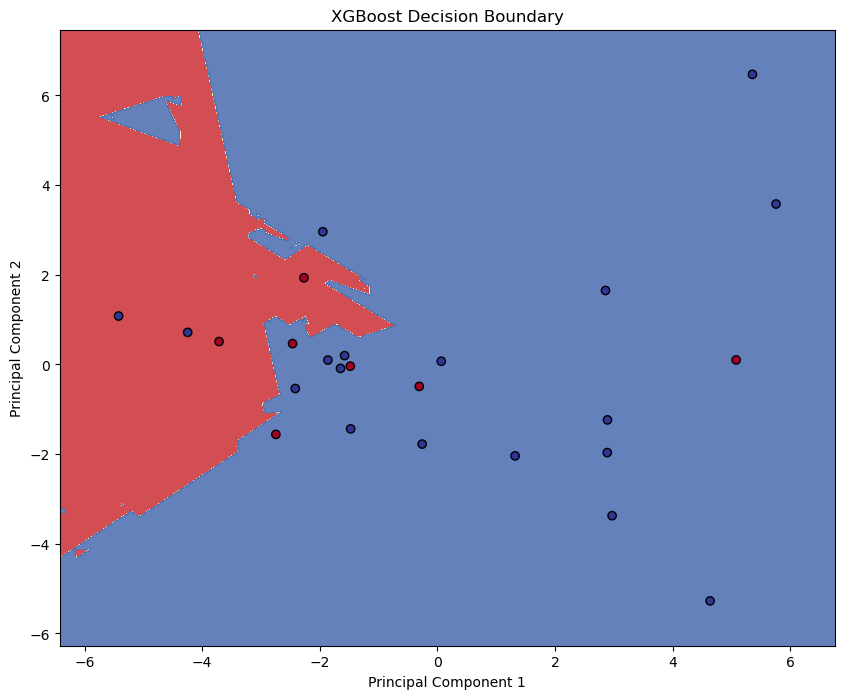

2024-12-31 14:25:10,018 [INFO] __main__: Decision boundary plot displayed successfully.
2024-12-31 14:25:10,019 [WARNING] __main__: Unsupported model: Random Forest. Skipping.
2024-12-31 14:25:10,020 [WARNING] __main__: Unsupported model: Decision Tree. Skipping.
2024-12-31 14:25:10,021 [INFO] __main__: ✅ Best model is XGBoost with Log Loss=0.6711150121950691
2024-12-31 14:25:10,042 [INFO] __main__: Model saved to /workspaces/spl_freethrow_biomechanics_analysis_ml_prediction/ml-preprocessing-utils/data/dataset/test/models/XGBoost_model.pkl
2024-12-31 14:25:10,047 [INFO] __main__: ✅ Model 'XGBoost_model.pkl' saved successfully in '/workspaces/spl_freethrow_biomechanics_analysis_ml_prediction/ml-preprocessing-utils/data/dataset/test/models'.
2024-12-31 14:25:10,060 [INFO] __main__: ✅ Tuning results saved to ../../ml-preprocessing-utils/data/dataset/test/models/tuning_results.json.
2024-12-31 14:25:10,061 [INFO] __main__: ✅ Training workflow completed successfully.


In [26]:
# src/ml/train.py

import logging
import os
import json
from typing import Any, Dict
import yaml
import pandas as pd
import joblib  # Ensure joblib is imported

# Local imports - Adjust the import paths based on your project structure
# from feature_manager import FeatureManager
# from data_preprocessor import DataPreprocessor
# from train_utils.train_utils import (
#     evaluate_model, save_model, load_model, plot_decision_boundary,
#     tune_random_forest, tune_xgboost, tune_decision_tree
# )

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(name)s: %(message)s")
logger = logging.getLogger(__name__)

def load_config(config_path: str) -> Dict[str, Any]:
    """
    Load configuration from a YAML file.

    Args:
        config_path (str): Path to the configuration file.

    Returns:
        Dict[str, Any]: Configuration dictionary.
    """
    try:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        logger.info(f"✅ Configuration loaded from {config_path}.")
        return config
    except Exception as e:
        logger.error(f"❌ Failed to load configuration: {e}")
        raise

def bayes_best_model_train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    selection_metric: str,
    model_save_dir: str,
    classification_save_path: str,
    tuning_results_save: str,
    selected_models: Any,
    use_pca: bool = False
):
    """
    A streamlined function that:
      1) Tunes and trains models using Bayesian optimization.
      2) Evaluates the best model.
      3) Saves the tuning results and best model.

    Args:
        X_train, y_train: Training features and labels.
        X_test, y_test: Test features and labels.
        selection_metric (str): Metric to select best model (e.g., "Log Loss", "accuracy").
        model_save_dir (str): Directory to save the best model.
        classification_save_path (str): Path to save classification report.
        tuning_results_save (str): Path to save tuning results in JSON format.
        selected_models (list|str): List of models (e.g. ["XGBoost", "Random Forest"]) or a single string.
        use_pca (bool): If True, uses PCA for boundary plotting. Typically False for tree-based models.
    """
    logger.info("Starting the Bayesian hyperparameter tuning process...")

    # Scoring metric selection
    scoring_metric = "neg_log_loss" if selection_metric.lower() == "log loss" else "accuracy"

    # Prepare model registry
    model_registry = {
        "XGBoost": tune_xgboost,
        # "Random Forest": tune_random_forest,
        # "Decision Tree": tune_decision_tree
    }

    # Normalize selected_models input
    if isinstance(selected_models, str):
        selected_models = [selected_models]
    elif not selected_models:
        selected_models = list(model_registry.keys())
        logger.info(f"No models specified. Using all available: {selected_models}")

    tuning_results = {}
    best_model_name = None
    best_model = None
    best_metric_value = None

    # Loop over requested models
    for model_name in selected_models:
        if model_name not in model_registry:
            logger.warning(f"Unsupported model: {model_name}. Skipping.")
            continue
        try:
            logger.info(f"📌 Tuning hyperparameters for {model_name}...")
            tuner_func = model_registry[model_name]

            best_params, best_score, best_estimator = tuner_func(
                X_train, y_train, scoring_metric=scoring_metric
            )
            logger.info(f"✅ {model_name} tuning done. Best Params: {best_params}, Best CV Score: {best_score}")

            # Evaluate on X_test
            metrics = evaluate_model(best_estimator, X_test, y_test, save_path=classification_save_path)
            metric_value = metrics.get(selection_metric.lower().replace(" ", "_"))  # Adjust key

            if metric_value is not None:
                logger.debug(f"Metric value for {selection_metric}: {metric_value}")
                if best_metric_value is None:
                    best_metric_value = metric_value
                    best_model_name = model_name
                    best_model = best_estimator
                    logger.debug(f"Best model set to {best_model_name} with {selection_metric}={best_metric_value}")
                else:
                    # For log loss, lower is better
                    if selection_metric.lower() == "log loss" and metric_value < best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
                    # For other metrics (accuracy, f1, etc.), higher is better
                    elif selection_metric.lower() != "log loss" and metric_value > best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
            else:
                logger.debug(f"Metric value for {selection_metric} is None. Best model not updated.")

            # Save partial results
            tuning_results[model_name] = {
                "Best Params": best_params,
                "Best CV Score": best_score,
                "Evaluation Metrics": metrics,
            }

            # Plot boundary (optional for tree-based with PCA)
            try:
                plot_decision_boundary(best_estimator, X_test, y_test, f"{model_name} Decision Boundary", use_pca=use_pca)
            except ValueError as e:
                logger.warning(f"Skipping decision boundary plot for {model_name}: {e}")

        except Exception as e:
            logger.error(f"❌ Error tuning {model_name}: {e}")
            continue

    # Save best model
    if best_model_name:
        logger.info(f"✅ Best model is {best_model_name} with {selection_metric}={best_metric_value}")
        try:
            absolute_save_dir = os.path.abspath(model_save_dir)
            logger.debug(f"Absolute model save directory: {absolute_save_dir}")
            os.makedirs(absolute_save_dir, exist_ok=True)
            logger.debug(f"Ensured that the model save directory '{absolute_save_dir}' exists.")

            logger.debug(f"Attempting to save model '{best_model_name}' to '{absolute_save_dir}'.")
            logger.debug("Calling save_model function...")
            save_model(best_model, best_model_name, save_dir=absolute_save_dir)
            logger.debug("save_model function called successfully.")
            logger.info(f"✅ Model '{best_model_name}_model.pkl' saved successfully in '{absolute_save_dir}'.")

            # Confirm the model file exists
            model_file_path = os.path.join(absolute_save_dir, f"{best_model_name}_model.pkl")
            if os.path.isfile(model_file_path):
                logger.debug(f"Model file exists: {model_file_path}")
            else:
                logger.error(f"Model file was not found after saving: {model_file_path}")

            # List directory contents
            logger.debug(f"Directory contents after saving: {os.listdir(absolute_save_dir)}")

        except Exception as e:
            logger.error(f"❌ Failed to save best model {best_model_name}: {e}")
            raise  # Ensure the exception is propagated
    else:
        logger.warning("⚠️ No best model was selected. Tuning might have failed for all models.")

    # Save tuning results
    try:
        with open(tuning_results_save, "w") as f:
            json.dump(tuning_results, f, indent=4)
        logger.info(f"✅ Tuning results saved to {tuning_results_save}.")
    except Exception as e:
        logger.error(f"❌ Error saving tuning results: {e}")

def main():
    # ----------------------------
    # 1. Load Configuration
    # ----------------------------
    config = load_config('../../ml-preprocessing-utils/data/dataset/test/preprocessor_config/preprocessor_config.yaml')

    # Global paths
    model_save_dir = config.get('execution', {}).get('train', {}).get('model_save_path', '../../ml-preprocessing-utils/data/dataset/test/models')
    tuning_results_save = os.path.join(model_save_dir, "tuning_results.json")
    classification_save_path = os.path.join(model_save_dir, "classification_report.txt")
    plots_dir = config.get('execution', {}).get('shared', {}).get('plot_output_dir', '../../ml-preprocessing-utils/data/dataset/test/plots')

    # Extract model-related config
    selected_models = config.get('models', {}).get('selected_models', ["XGBoost", "Random Forest", "Decision Tree"])
    selection_metric = config.get('models', {}).get('selection_metric', "Log Loss")

    # Extract Tree Based Classifier options from config
    tree_classifier_options = config.get('models', {}).get('Tree Based Classifier', {})

    # ----------------------------
    # 2. Initialize and Use FeatureManager
    # ----------------------------
    # Initialize FeatureManager with the desired save_path
    save_path = config.get('execution', {}).get('shared', {}).get('features_metadata_path', '../../ml-preprocessing-utils/data/dataset/test/features_info/features_metadata.pkl')
    feature_manager = FeatureManager(save_path=save_path)
    try:
        # Load the dataset and column assets from the metadata
        filtered_df, column_assets = feature_manager.load_features_and_dataset(debug=False)
        logger.info("✅ Filtered dataset and column assets loaded successfully via FeatureManager.")
    except Exception as e:
        logger.error(f"❌ Failed to load dataset and metadata: {e}")
        return

    # ----------------------------
    # 3. Initialize DataPreprocessor
    # ----------------------------
    # We assume a supervised classification use case: "Tree Based Classifier"
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        column_assets=column_assets,
        mode='train',
        options=tree_classifier_options,  # The options from config for "Tree Based Classifier"
        debug=config.get('logging', {}).get('debug', False),  # or config-based
        normalize_debug=config.get('execution', {}).get('train', {}).get('normalize_debug', False),
        normalize_graphs_output=config.get('execution', {}).get('train', {}).get('normalize_graphs_output', False),
        graphs_output_dir=config.get('execution', {}).get('shared', {}).get('plot_output_dir', '../../ml-preprocessing-utils/data/dataset/test/plots'),
        transformers_dir=config.get('execution', {}).get('train', {}).get('save_transformers_path', '../../ml-preprocessing-utils/data/dataset/test/transformers')
    )

    # ----------------------------
    # 4. Execute Preprocessing
    # ----------------------------
    try:
        # Execute preprocessing by passing the entire filtered_df
        X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(filtered_df)
        
        logger.info(f"✅ Preprocessing complete. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    except Exception as e:
        logger.error(f"❌ Error during preprocessing: {e}")
        return

    # ----------------------------
    # 5. Train & Tune the Model
    # ----------------------------
    try:
        bayes_best_model_train(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            selection_metric=selection_metric,
            model_save_dir=model_save_dir,
            classification_save_path=classification_save_path,
            tuning_results_save=tuning_results_save,
            selected_models=selected_models,
            use_pca=True  
        )
    except Exception as e:
        logger.error(f"❌ Model training/tuning failed: {e}")
        return

    # ----------------------------
    # 6. Load and Use the Saved Model (Optional)
    # ----------------------------
    # This step can be considered optional since predictions are handled in predict.py
    # If you still need to verify the saved model here, you can do so
    """
    load_model_name = "XGBoost"
    model_file_path = os.path.join(os.path.abspath(model_save_dir), f"{load_model_name}_model.pkl")
    
    if os.path.isfile(model_file_path):
        logger.info(f"Loading model: {load_model_name} from {model_file_path}")
        try:
            loaded_model = load_model(load_model_name, save_dir=model_save_dir)
            predictions = loaded_model.predict(X_test)
            logger.info(f"Predictions from loaded model: {predictions}")
        except Exception as e:
            logger.error(f"❌ Failed to load or use the model: {e}")
            return
    else:
        logger.error(f"❌ Model file '{model_file_path}' does not exist. Cannot load the model.")
        return
    
    # Integrate predictions
    try:
        if X_test_inverse is not None:
            # Insert predictions into the inverse-transformed DataFrame
            X_test_inverse['Prediction'] = predictions
            logger.debug("Predictions attached to inverse-transformed DataFrame.")
    except Exception as e:
        logger.error(f"❌ Inverse transformation failed: {e}")
    """

    logger.info("✅ Training workflow completed successfully.")

if __name__ == "__main__":
    main()


In [27]:
# src/freethrow_predictions/ml/predict.py

import logging
import os
from typing import Any, Dict
import yaml
import pandas as pd
import joblib

# Local imports
# from data_preprocessor import DataPreprocessor  # Ensure correct import path

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(name)s: %(message)s")
logger = logging.getLogger(__name__)

def load_config(config_path: str) -> Dict[str, Any]:
    try:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        logger.info(f"✅ Configuration loaded from {config_path}.")
        return config
    except Exception as e:
        logger.error(f"❌ Failed to load configuration: {e}")
        raise

def load_dataset(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

def main():
    # ----------------------------
    # 1. Load Configuration
    # ----------------------------
    config_path = '../../ml-preprocessing-utils/data/dataset/test/preprocessor_config/preprocessor_config.yaml'
    try:
        config = load_config(config_path)
    except Exception as e:
        logger.error(f"❌ Cannot proceed without configuration: {e}")
        return

    # ----------------------------
    # 2. Configure Logging
    # ----------------------------
    logger_config = config.get('logging', {})
    logger_level = logger_config.get('level', 'INFO').upper()
    logger_format = logger_config.get('format', '%(asctime)s [%(levelname)s] %(message)s')
    debug_flag = config.get('logging', {}).get('debug', False)
    logging.getLogger().setLevel(logging.DEBUG if debug_flag else getattr(logging, logger_level, logging.INFO))
    logger = logging.getLogger('predict_preprocessing')

    # ----------------------------
    # 3. Extract Feature Assets and Execution Parameters for Predict
    # ----------------------------
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),  # Not used in predict
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }

    execution_predict = config.get('execution', {}).get('predict', {})
    prediction_input_path = execution_predict.get('prediction_input_path', '')
    load_transformers_path = execution_predict.get('load_transformers_path', '')
    trained_model_path = execution_predict.get('trained_model_path', '')
    predictions_output_path = execution_predict.get('predictions_output_path', './predictions')
    normalize_debug = execution_predict.get('normalize_debug', False)
    normalize_graphs_output = execution_predict.get('normalize_graphs_output', False)

    # Validate essential paths
    if not prediction_input_path:
        logger.error("❌ 'prediction_input_path' for predict mode is not specified in the configuration.")
        return
    if not os.path.exists(prediction_input_path):
        logger.error(f"❌ Prediction input dataset not found at {prediction_input_path}.")
        return
    if not load_transformers_path:
        logger.error("❌ 'load_transformers_path' for predict mode is not specified in the configuration.")
        return
    if not os.path.exists(load_transformers_path):
        logger.error(f"❌ Transformers file not found at {load_transformers_path}.")
        return
    if not trained_model_path:
        logger.error("❌ 'trained_model_path' for predict mode is not specified in the configuration.")
        return
    if not os.path.exists(trained_model_path):
        logger.error(f"❌ Trained model not found at {trained_model_path}.")
        return

    # ----------------------------
    # 4. Initialize DataPreprocessor in Predict Mode
    # ----------------------------
    try:
        preprocessor = DataPreprocessor(
            model_type=config.get('model_type', 'Tree Based Classifier'),
            column_assets=column_assets,
            mode='predict',
            options=config.get('models', {}).get(config.get('model_type', 'Tree Based Classifier'), {}),
            debug=debug_flag,
            normalize_debug=normalize_debug,
            normalize_graphs_output=normalize_graphs_output,
            graphs_output_dir=config.get('execution', {}).get('shared', {}).get('plot_output_dir', './plots'),
            transformers_dir=os.path.dirname(load_transformers_path)
        )
        logger.info("✅ DataPreprocessor initialized in 'predict' mode.")
    except Exception as e:
        logger.error(f"❌ Failed to initialize DataPreprocessor: {e}")
        return

    # ----------------------------
    # 5. Load Trained Transformers
    # ----------------------------
    try:
        transformers = preprocessor.load_transformers()
        logger.info("✅ Transformers loaded successfully.")
    except Exception as e:
        logger.error(f"❌ Failed to load transformers: {e}")
        return

    # ----------------------------
    # 6. Load Trained Model
    # ----------------------------
    try:
        model = joblib.load(trained_model_path)
        logger.info(f"✅ Trained model loaded from '{trained_model_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load trained model: {e}")
        return

    # ----------------------------
    # 7. Load Prediction Input Data
    # ----------------------------
    try:
        X_new = load_dataset(prediction_input_path)
        logger.info(f"✅ Prediction input data loaded from '{prediction_input_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load prediction input data: {e}")
        return

    # ----------------------------
    # 8. Preprocess the New Data
    # ----------------------------
    try:
        X_new_preprocessed = preprocessor.transform(X_new)
        logger.info("✅ New data preprocessed successfully.")
    except Exception as e:
        logger.error(f"❌ Preprocessing of new data failed: {e}")
        return

    # ----------------------------
    # 9. Make Predictions
    # ----------------------------
    try:
        predictions = model.predict(X_new_preprocessed)
        logger.info("✅ Predictions made successfully on new data.")

        # If the model supports predict_proba, get probabilities
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_new_preprocessed)[:, 1]
            X_new['Prediction_Probability'] = y_proba
            logger.info("✅ Predicted probabilities added to the dataset.")
        else:
            logger.info("⚠️ Model does not support probability predictions.")

        # Add predictions to the original prediction dataset
        X_new['Prediction'] = predictions
        logger.info("✅ Predictions integrated into the dataset successfully.")
    except Exception as e:
        logger.error(f"❌ Failed to make predictions: {e}")
        return

    # ----------------------------
    # 10. Inverse Transform the Data for Interpretability
    # ----------------------------
    try:
        X_new_inverse = preprocessor.inverse_transform_data(X_new_preprocessed)
        logger.info("✅ Inverse transformations applied successfully.")
        logger.info(f"Inverse-transformed X_new_inverse.shape={X_new_inverse.shape}")
    except Exception as e:
        logger.error(f"❌ Inverse transformations failed: {e}")
        # Proceed with predictions only
        X_new_inverse = pd.DataFrame({'Prediction': predictions})
        logger.warning("Inverse transformation was not applied. Proceeding with predictions only.")

    # Attach predictions to inverse-transformed DataFrame
    try:
        if X_new_inverse is not None and 'Prediction' not in X_new_inverse.columns:
            X_new_inverse['Prediction'] = predictions
            logger.debug("Predictions attached to inverse-transformed DataFrame.")
    except Exception as e:
        logger.error(f"❌ Failed to attach predictions to inverse-transformed DataFrame: {e}")
        X_new_inverse = pd.DataFrame({'Prediction': predictions})  # Assign to X_new_inverse

    # ----------------------------
    # 11. Save Predictions
    # ----------------------------
    try:
        os.makedirs(predictions_output_path, exist_ok=True)
        X_new_inverse.to_csv(os.path.join(predictions_output_path, 'predictions.csv'), index=False)
        logger.info(f"✅ Predictions saved to '{predictions_output_path}/predictions.csv'.")
    except Exception as e:
        logger.error(f"❌ Failed to save predictions: {e}")
        return

    # ----------------------------
    # 12. Display Predictions
    # ----------------------------
    try:
        print("\nInverse Transformed Prediction DataFrame with Predictions:")
        print(X_new_inverse.head())
    except Exception as e:
        logger.error(f"❌ Error during displaying predictions: {e}")
        return

    logger.info("✅ Predict mode executed successfully.")

if __name__ == "__main__":
    main()


2024-12-31 14:25:10,107 [INFO] __main__: ✅ Configuration loaded from ../../ml-preprocessing-utils/data/dataset/test/preprocessor_config/preprocessor_config.yaml.


2024-12-31 14:25:10,114 [INFO] predict_preprocessing: ✅ DataPreprocessor initialized in 'predict' mode.


2024-12-31 14:25:10,115 [INFO] Step: Load Transformers


2024-12-31 14:25:10,115 [INFO] DataPreprocessor: Step: Load Transformers


2024-12-31 14:25:10,123 [INFO] Transformers loaded successfully from '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.


2024-12-31 14:25:10,123 [INFO] DataPreprocessor: Transformers loaded successfully from '../../ml-preprocessing-utils/data/dataset/test/transformers/transformers.pkl'.
2024-12-31 14:25:10,124 [INFO] predict_preprocessing: ✅ Transformers loaded successfully.
2024-12-31 14:25:10,138 [INFO] predict_preprocessing: ✅ Trained model loaded from '../../ml-preprocessing-utils/data/dataset/test/models/XGBoost_model.pkl'.
2024-12-31 14:25:10,152 [INFO] predict_preprocessing: ✅ Prediction input data loaded from '../../ml-preprocessing-utils/data/dataset/test/data/final_ml_dataset.csv'.


2024-12-31 14:25:10,156 [INFO] Data transformed.


2024-12-31 14:25:10,156 [INFO] DataPreprocessor: Data transformed.
2024-12-31 14:25:10,157 [INFO] predict_preprocessing: ✅ New data preprocessed successfully.
2024-12-31 14:25:10,166 [INFO] predict_preprocessing: ✅ Predictions made successfully on new data.
2024-12-31 14:25:10,171 [INFO] predict_preprocessing: ✅ Predicted probabilities added to the dataset.
2024-12-31 14:25:10,172 [INFO] predict_preprocessing: ✅ Predictions integrated into the dataset successfully.
2024-12-31 14:25:10,175 [INFO] InverseTransform: ✅ Inverse transformation completed successfully.
2024-12-31 14:25:10,176 [INFO] predict_preprocessing: ✅ Inverse transformations applied successfully.
2024-12-31 14:25:10,176 [INFO] predict_preprocessing: Inverse-transformed X_new_inverse.shape=(125, 15)
2024-12-31 14:25:10,191 [INFO] predict_preprocessing: ✅ Predictions saved to '../../ml-preprocessing-utils/data/dataset/test/data/predictions.csv'.

Inverse Transformed Prediction DataFrame with Predictions:
   release_ball_di

In [152]:
#%%writefile ../../src/freethrow_predictions/ml/shap/shap_utils.py

import logging
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle


def setup_logging(debug: bool = False) -> logging.Logger:
    """
    Configure and return a logger.

    :param debug: If True, set logging level to DEBUG. Otherwise, INFO.
    :return: Configured logger.
    """
    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(level=level, 
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')
    logger = logging.getLogger(__name__)
    return logger


def compute_shap_values(model, X_transformed: pd.DataFrame, debug: bool = False, logger: logging.Logger = None):
    """
    Compute SHAP values for the transformed data.

    :param model: Trained machine learning model.
    :param X_transformed: Transformed features used for prediction (pd.DataFrame).
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    :return: Tuple of (explainer, shap_values).
    """
    if logger:
        logger.info("Initializing SHAP explainer...")
    try:
        explainer = shap.Explainer(model, X_transformed)
        shap_values = explainer(X_transformed)
        if logger:
            logger.info("SHAP values computed successfully.")
            if debug:
                logger.debug(f"SHAP values shape: {shap_values.values.shape}")
    except Exception as e:
        if logger:
            logger.error(f"SHAP value computation failed: {e}")
        raise
    return explainer, shap_values


def plot_shap_summary(shap_values, X_original: pd.DataFrame, save_path: str, debug: bool = False, 
                      logger: logging.Logger = None):
    """
    Generate and save a SHAP summary plot.

    :param shap_values: SHAP values computed for the dataset.
    :param X_original: Original (untransformed) feature DataFrame.
    :param save_path: Full file path to save the plot.
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    """
    if logger:
        logger.info("Generating SHAP summary plot...")
    try:
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_original, show=False)
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        if logger and debug:
            logger.debug(f"SHAP summary plot saved to {save_path}")
        if logger:
            logger.info("SHAP summary plot generated successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate SHAP summary plot: {e}")
        raise


def plot_shap_dependence(shap_values, feature: str, X_original: pd.DataFrame, save_path: str, debug: bool = False, 
                         logger: logging.Logger = None):
    """
    Generate and save a SHAP dependence plot for a specific feature.

    :param shap_values: SHAP values computed for the dataset.
    :param feature: Feature name to generate the dependence plot for.
    :param X_original: Original (untransformed) feature DataFrame.
    :param save_path: Full file path to save the plot.
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    """
    if logger:
        logger.info(f"Generating SHAP dependence plot for feature '{feature}'...")
    try:
        plt.figure(figsize=(8, 6))
        shap.dependence_plot(feature, shap_values.values, X_original, show=False)
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        if logger and debug:
            logger.debug(f"SHAP dependence plot for '{feature}' saved to {save_path}")
        if logger:
            logger.info(f"SHAP dependence plot for feature '{feature}' generated successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate SHAP dependence plot for feature '{feature}': {e}")
        raise


def generate_global_recommendations(shap_values, X_original: pd.DataFrame, top_n: int = 5, debug: bool = False, 
                                    use_mad: bool = False, logger: logging.Logger = None) -> dict:
    """
    Generate global recommendations based on SHAP values and feature distributions.

    :param shap_values: SHAP values computed for the dataset.
    :param X_original: Original (untransformed) feature DataFrame.
    :param top_n: Number of top features to generate recommendations for.
    :param debug: If True, enable detailed debug logs.
    :param use_mad: If True, use Median Absolute Deviation for range definition.
    :param logger: Logger instance for logging.
    :return: recommendations: Dictionary mapping features to recommended value ranges, importance, and direction.
    """
    if logger:
        logger.info("Generating feature importance based on SHAP values...")
    try:
        shap_df = pd.DataFrame(shap_values.values, columns=X_original.columns)
        
        # Calculate mean absolute SHAP values for importance
        feature_importance = pd.DataFrame({
            'feature': X_original.columns,
            'importance': np.abs(shap_df).mean(axis=0),
            'mean_shap': shap_df.mean(axis=0)
        }).sort_values(by='importance', ascending=False)
        
        if logger and debug:
            logger.debug(f"Feature importance (top {top_n}):\n{feature_importance.head(top_n)}")
        
        top_features = feature_importance.head(top_n)['feature'].tolist()
        recommendations = {}
        
        for feature in top_features:
            feature_values = X_original[feature]
            
            if use_mad:
                # Use Median and MAD for robust statistics
                median = feature_values.median()
                mad = feature_values.mad()
                lower_bound = median - 1.5 * mad
                upper_bound = median + 1.5 * mad
                range_str = f"{lower_bound:.1f}–{upper_bound:.1f}"
            else:
                # Default to Interquartile Range (IQR)
                lower_bound = feature_values.quantile(0.25)
                upper_bound = feature_values.quantile(0.75)
                range_str = f"{lower_bound:.1f}–{upper_bound:.1f}"
            
            # Determine direction based on mean SHAP value
            mean_shap = feature_importance.loc[feature_importance['feature'] == feature, 'mean_shap'].values[0]
            direction = 'positive' if mean_shap > 0 else 'negative'
            
            recommendations[feature] = {
                'range': range_str,
                'importance': round(feature_importance.loc[feature_importance['feature'] == feature, 'importance'].values[0], 4),  # Rounded for readability
                'direction': direction
            }
            if logger and debug:
                logger.debug(f"Recommendation for {feature}: Range={range_str}, Importance={feature_importance.loc[feature_importance['feature'] == feature, 'importance'].values[0]}, Direction={direction}")
        
        if logger and debug:
            logger.debug(f"Final Recommendations with Importance and Direction: {recommendations}")
        return recommendations
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate global recommendations: {e}")
        raise


def generate_individual_feedback(trial: pd.Series, shap_values_trial: np.ndarray, feature_metadata: dict = None, 
                                 logger: logging.Logger = None) -> dict:
    """
    Generate specific feedback for a single trial based on its SHAP values and feature metadata.

    Args:
        trial (pd.Series): A single trial's data.
        shap_values_trial (np.ndarray): SHAP values for the trial.
        feature_metadata (dict, optional): Additional metadata for features (e.g., units).
        logger (logging.Logger, optional): Logger instance for logging.

    Returns:
        dict: Feedback messages for each feature.
    """
    feedback = {}
    feature_names = trial.index.tolist()

    for feature, shap_value in zip(feature_names, shap_values_trial):
        if shap_value > 0:
            adjustment = "maintain or increase"
            direction = "positively"
        elif shap_value < 0:
            adjustment = "decrease"
            direction = "positively"
        else:
            feedback[feature] = f"{feature.replace('_', ' ').capitalize()} has no impact on the prediction."
            continue

        # Map SHAP values to meaningful adjustment magnitudes
        # Example: 10% of the current feature value
        current_value = trial[feature]
        adjustment_factor = 0.1
        adjustment_amount = adjustment_factor * abs(current_value)

        # Incorporate feature metadata if available
        if feature_metadata and feature in feature_metadata:
            unit = feature_metadata[feature].get('unit', '')
            adjustment_str = f"{adjustment_amount:.2f} {unit}" if unit else f"{adjustment_amount:.2f}"
        else:
            adjustment_str = f"{adjustment_amount:.2f}"

        # Construct feedback message
        feedback_message = (
            f"Consider to {adjustment} '{feature.replace('_', ' ')}' by approximately {adjustment_str} "
            f"to {direction} influence the result."
        )
        feedback[feature] = feedback_message

    return feedback


def compute_individual_shap_values(explainer, X_transformed: pd.DataFrame, trial_index: int, 
                                   logger: logging.Logger = None):
    """
    Compute SHAP values for a single trial.

    :param explainer: SHAP explainer object.
    :param X_transformed: Transformed features used for prediction.
    :param trial_index: Index of the trial.
    :param logger: Logger instance.
    :return: shap_values for the trial.
    """
    if logger:
        logger.info(f"Computing SHAP values for trial at index {trial_index}...")
    try:
        trial = X_transformed.iloc[[trial_index]]
        shap_values = explainer(trial)
        if logger:
            logger.debug(f"SHAP values for trial {trial_index} computed successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to compute SHAP values for trial {trial_index}: {e}")
        raise
    return shap_values


def plot_individual_shap_force(shap_explainer, shap_values, X_original: pd.DataFrame, trial_index: int, 
                               save_path: str, logger: logging.Logger = None):
    """
    Generate and save a SHAP force plot for a specific trial.

    :param shap_explainer: SHAP explainer object.
    :param shap_values: SHAP values for the trial.
    :param X_original: Original feature DataFrame.
    :param trial_index: Index of the trial.
    :param save_path: Full file path to save the force plot.
    :param logger: Logger instance.
    """
    if logger:
        logger.info(f"Generating SHAP force plot for trial {trial_index}...")
    try:
        shap_plot = shap.force_plot(
            shap_explainer.expected_value, 
            shap_values.values[0], 
            X_original.iloc[trial_index],
            matplotlib=False
        )
        shap.save_html(save_path, shap_plot)
        if logger:
            logger.debug(f"SHAP force plot saved to {save_path}")
            logger.info(f"SHAP force plot for trial {trial_index} generated successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate SHAP force plot for trial {trial_index}: {e}")
        raise


def extract_force_plot_values(shap_values, trial_index: int, logger: logging.Logger = None) -> dict:
    """
    Extract SHAP values and feature contributions for a specific trial.

    Args:
        shap_values (shap.Explanation): SHAP values object.
        trial_index (int): Index of the trial.
        logger (logging.Logger, optional): Logger instance.

    Returns:
        dict: Dictionary of feature contributions.
    """
    try:
        shap_values_instance = shap_values.values[trial_index]
        features_instance = shap_values.data[trial_index]
        feature_contributions = dict(zip(shap_values.feature_names, shap_values_instance))
        if logger and logger.isEnabledFor(logging.DEBUG):
            logger.debug(f"SHAP values for trial {trial_index}: {feature_contributions}")
        return feature_contributions
    except Exception as e:
        if logger:
            logger.error(f"Error extracting SHAP values for trial {trial_index}: {e}")
        raise


def save_shap_values(shap_values, save_path: str, logger: logging.Logger = None):
    """
    Save SHAP values to a file using pickle.

    :param shap_values: SHAP values object to save.
    :param save_path: File path to save the SHAP values.
    :param logger: Logger instance.
    """
    if logger:
        logger.info(f"Saving SHAP values to {save_path}...")
    try:
        with open(save_path, "wb") as f:
            pickle.dump(shap_values, f)
        if logger:
            logger.info(f"SHAP values saved successfully to {save_path}.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to save SHAP values: {e}")
        raise


def load_shap_values(load_path: str, logger: logging.Logger = None):
    """
    Load SHAP values from a pickle file.

    :param load_path: File path to load the SHAP values from.
    :param logger: Logger instance.
    :return: Loaded SHAP values object.
    """
    if logger:
        logger.info(f"Loading SHAP values from {load_path}...")
    try:
        with open(load_path, "rb") as f:
            shap_values = pickle.load(f)
        if logger:
            logger.info(f"SHAP values loaded successfully from {load_path}.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to load SHAP values: {e}")
        raise
    return shap_values


In [155]:
# src/freethrow_predictions/ml/predict.py

import logging
import os
from typing import Any, Dict, Tuple
import yaml
import pandas as pd
import joblib
import json

# Local imports
# from shap_utils import (
#     setup_logging,
#     compute_shap_values,
#     plot_shap_summary,
#     plot_shap_dependence,
#     generate_global_recommendations,
#     generate_individual_feedback,
#     save_shap_values,
#     load_shap_values
# )
# from classification_processors.datapreprocessor_class import DataPreprocessor
# from classification_processors.inverse_preprocessor_class import InversePreprocessor

def load_config(config_path: str) -> Dict[str, Any]:
    """
    Load the YAML configuration file.

    :param config_path: Path to the configuration file.
    :return: Configuration as a dictionary.
    """
    try:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        return config
    except Exception as e:
        raise FileNotFoundError(f"Failed to load configuration file: {e}")

def load_dataset(path: str) -> pd.DataFrame:
    """
    Load the dataset from a CSV file.

    :param path: Path to the CSV file.
    :return: DataFrame containing the dataset.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

def main():
    # ----------------------------
    # 1. Load Configuration
    # ----------------------------
    config_path = '../../ml-preprocessing-utils/data/dataset/test/preprocessor_config/preprocessor_config.yaml'
    try:
        config = load_config(config_path)
    except Exception as e:
        logging.error(f"❌ Cannot proceed without configuration: {e}")
        return

    # ----------------------------
    # 2. Configure Logging
    # ----------------------------
    debug_flag = config.get('logging', {}).get('debug', False)
    logger = setup_logging(debug=debug_flag)

    # ----------------------------
    # 3. Extract Feature Assets and Execution Parameters for Predict
    # ----------------------------
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),  # Not used in predict
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }

    execution_predict = config.get('execution', {}).get('predict', {})
    prediction_input_path = execution_predict.get('prediction_input_path', '')
    load_transformers_path = execution_predict.get('load_transformers_path', '')
    trained_model_path = execution_predict.get('trained_model_path', '')
    predictions_output_path = execution_predict.get('predictions_output_path', './predictions')
    normalize_debug = execution_predict.get('normalize_debug', False)
    normalize_graphs_output = execution_predict.get('normalize_graphs_output', False)
    shap_output_path = execution_predict.get('shap_output_path', './shap_outputs')
    recommendations_output_path = execution_predict.get('recommendations_output_path', './recommendations')
    specific_feedback_output_path = execution_predict.get('specific_feedback_output_path', './feedback')

    # Validate essential paths
    essential_paths = {
        'prediction_input_path': prediction_input_path,
        'load_transformers_path': load_transformers_path,
        'trained_model_path': trained_model_path
    }

    for key, path in essential_paths.items():
        if not path:
            logger.error(f"❌ '{key}' for predict mode is not specified in the configuration.")
            return
        if not os.path.exists(path):
            logger.error(f"❌ {key} not found at {path}.")
            return

    # ----------------------------
    # 4. Initialize DataPreprocessor in Predict Mode
    # ----------------------------
    try:
        preprocessor = DataPreprocessor(
            model_type=config.get('model_type', 'Tree Based Classifier'),
            column_assets=column_assets,
            mode='predict',
            options=config.get('models', {}).get(config.get('model_type', 'Tree Based Classifier'), {}),
            debug=debug_flag,
            normalize_debug=normalize_debug,
            normalize_graphs_output=normalize_graphs_output,
            graphs_output_dir=config.get('execution', {}).get('shared', {}).get('plot_output_dir', './plots'),
            transformers_dir=os.path.dirname(load_transformers_path)
        )
        logger.info("✅ DataPreprocessor initialized in 'predict' mode.")
    except Exception as e:
        logger.error(f"❌ Failed to initialize DataPreprocessor: {e}")
        return

    # ----------------------------
    # 5. Load Trained Transformers
    # ----------------------------
    try:
        transformers = preprocessor.load_transformers()
        logger.info("✅ Transformers loaded successfully.")
    except Exception as e:
        logger.error(f"❌ Failed to load transformers: {e}")
        return

    # ----------------------------
    # 6. Load Trained Model
    # ----------------------------
    try:
        model = joblib.load(trained_model_path)
        logger.info(f"✅ Trained model loaded from '{trained_model_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load trained model: {e}")
        return

    # ----------------------------
    # 7. Load Prediction Input Data
    # ----------------------------
    try:
        X_new = load_dataset(prediction_input_path)
        logger.info(f"✅ Prediction input data loaded from '{prediction_input_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load prediction input data: {e}")
        return

    # ----------------------------
    # 8. Preprocess the New Data
    # ----------------------------
    try:
        X_new_preprocessed = preprocessor.transform(X_new)
        logger.info("✅ New data preprocessed successfully.")
    except Exception as e:
        logger.error(f"❌ Preprocessing of new data failed: {e}")
        return

    # ----------------------------
    # 9. Make Predictions
    # ----------------------------
    try:
        predictions = model.predict(X_new_preprocessed)
        logger.info("✅ Predictions made successfully on new data.")

        # If the model supports predict_proba, get probabilities
        if hasattr(model, "predict_proba"):
            prediction_probabilities = model.predict_proba(X_new_preprocessed)
            logger.info("✅ Predicted probabilities obtained.")
        else:
            logger.warning("⚠️ Model does not support probability predictions.")
            prediction_probabilities = None

        # Add predictions to the original prediction dataset
        X_new['Prediction'] = predictions
        logger.info("✅ Predictions integrated into the dataset successfully.")

        if prediction_probabilities is not None:
            classes = model.classes_
            if prediction_probabilities.shape[1] == 2:
                # Binary classification
                X_new['Prediction_Probability'] = prediction_probabilities[:, 1]
            else:
                # Multiclass classification
                for idx, class_label in enumerate(classes):
                    X_new[f'Prediction_Probability_Class_{class_label}'] = prediction_probabilities[:, idx]
            logger.info("✅ Prediction probabilities added to the dataset.")
    except Exception as e:
        logger.error(f"❌ Failed to make predictions: {e}")
        return

    # ----------------------------
    # 10. Inverse Transform the Data for Interpretability
    # ----------------------------
    try:
        X_new_inverse = preprocessor.inverse_transform_data(X_new_preprocessed)
        logger.info("✅ Inverse transformations applied successfully.")
        logger.info(f"Inverse-transformed X_new_inverse.shape={X_new_inverse.shape}")
    except Exception as e:
        logger.error(f"❌ Inverse transformations failed: {e}")
        X_new_inverse = pd.DataFrame({'predictions': predictions})  # Correct variable assignment

    # ----------------------------
    # 11. Save Predictions
    # ----------------------------
    try:
        os.makedirs(predictions_output_path, exist_ok=True)
        final_output_path = os.path.join(predictions_output_path, 'predictions.csv')
        X_new_inverse.to_csv(final_output_path, index=False)
        logger.info(f"✅ Predictions saved to '{final_output_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to save predictions: {e}")
        return

    # ----------------------------
    # 12. Compute SHAP Values
    # ----------------------------
    try:
        explainer, shap_values = compute_shap_values(model, X_new_preprocessed, debug=debug_flag, logger=logger)
        logger.info("✅ SHAP values computed successfully.")
    except Exception as e:
        logger.error(f"❌ Failed to compute SHAP values: {e}")
        return

    # ----------------------------
    # 13. Generate and Save SHAP Summary Plot
    # ----------------------------
    try:
        os.makedirs(shap_output_path, exist_ok=True)
        shap_summary_path = os.path.join(shap_output_path, 'shap_summary.png')
        plot_shap_summary(
            shap_values=shap_values,
            X_original=X_new,
            save_path=shap_summary_path,
            debug=debug_flag,
            logger=logger
        )
        logger.info(f"✅ SHAP summary plot saved to '{shap_summary_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to generate SHAP summary plot: {e}")

    # ----------------------------
    # 14. Generate and Save SHAP Dependence Plots
    # ----------------------------
    try:
        recommendations = generate_global_recommendations(
            shap_values=shap_values,
            X_original=X_new,
            top_n=10,  # Adjust based on your preference
            debug=debug_flag,
            use_mad=False,  # Set to True if using MAD for range definitions
            logger=logger
        )
        os.makedirs(shap_output_path, exist_ok=True)
        for feature in recommendations.keys():
            sanitized_feature = feature.replace(" ", "_").replace("/", "_")
            shap_dependence_path = os.path.join(shap_output_path, f'shap_dependence_{sanitized_feature}.png')
            plot_shap_dependence(
                shap_values=shap_values,
                feature=feature,
                X_original=X_new,
                save_path=shap_dependence_path,
                debug=debug_flag,
                logger=logger
            )
            logger.info(f"✅ SHAP dependence plot for '{feature}' saved to '{shap_dependence_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to generate SHAP dependence plots: {e}")

    # ----------------------------
    # 15. Save SHAP Values
    # ----------------------------
    try:
        shap_values_path = os.path.join(shap_output_path, 'shap_values.pkl')
        save_shap_values(shap_values, shap_values_path, logger=logger)
        logger.info(f"✅ SHAP values saved to '{shap_values_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to save SHAP values: {e}")

    # ----------------------------
    # 16. Save Global Recommendations
    # ----------------------------
    try:
        os.makedirs(recommendations_output_path, exist_ok=True)
        recommendations_path = os.path.join(recommendations_output_path, 'global_shap_recommendations.json')
        with open(recommendations_path, 'w') as f:
            json.dump(recommendations, f, indent=4)
        logger.info(f"✅ Global SHAP recommendations saved to '{recommendations_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to save global recommendations: {e}")

    # ----------------------------
    # 17. Generate Specific Feedback (Optional)
    # ----------------------------
    if config.get('execution', {}).get('include_specific_feedback', False):
        try:
            feature_metadata = {}
            for feature in X_new.columns:
                if 'angle' in feature.lower():
                    unit = 'degrees'
                else:
                    unit = 'units'  # Adjust based on your feature's unit
                feature_metadata[feature] = {'unit': unit}

            specific_feedback = generate_individual_feedback(
                trial=X_new,
                shap_values_trial=shap_values.values,
                feature_metadata=feature_metadata,
                logger=logger
            )
            X_new_inverse['specific_feedback'] = specific_feedback
            logger.info("✅ Specific feedback generated for each trial.")

            # Save specific feedback
            os.makedirs(specific_feedback_output_path, exist_ok=True)
            feedback_path = os.path.join(specific_feedback_output_path, 'specific_feedback.json')
            with open(feedback_path, 'w') as f:
                json.dump(specific_feedback, f, indent=4)
            logger.info(f"✅ Specific feedback saved to '{feedback_path}'.")
        except Exception as e:
            logger.error(f"❌ Failed to generate specific feedback: {e}")

    # ----------------------------
    # 18. Final Output Display
    # ----------------------------
    try:
        print("\nInverse Transformed Prediction DataFrame with Predictions:")
        print(X_new_inverse.head())
    except Exception as e:
        logger.error(f"❌ Error during displaying predictions: {e}")

    logger.info("✅ Predict pipeline executed successfully.")

if __name__ == "__main__":
    main()


2024-12-30 22:35:04,310 [INFO] __main__: ✅ DataPreprocessor initialized in 'predict' mode.


2024-12-30 22:35:04,311 [INFO] Step: Load Transformers


2024-12-30 22:35:04,311 [INFO] DataPreprocessor: Step: Load Transformers
2024-12-30 22:35:04,318 [INFO] __main__: ✅ Transformers loaded successfully.
2024-12-30 22:35:04,335 [INFO] __main__: ✅ Trained model loaded from '../../ml-preprocessing-utils/data/dataset/test/models/XGBoost_model.pkl'.
2024-12-30 22:35:04,347 [INFO] __main__: ✅ Prediction input data loaded from '../../ml-preprocessing-utils/data/dataset/test/data/final_ml_dataset.csv'.


2024-12-30 22:35:04,351 [INFO] Data transformed.


2024-12-30 22:35:04,351 [INFO] DataPreprocessor: Data transformed.
2024-12-30 22:35:04,352 [INFO] __main__: ✅ New data preprocessed successfully.
2024-12-30 22:35:04,369 [INFO] __main__: ✅ Predictions made successfully on new data.
2024-12-30 22:35:04,391 [INFO] __main__: ✅ Predicted probabilities obtained.
2024-12-30 22:35:04,396 [INFO] __main__: ✅ Predictions integrated into the dataset successfully.
2024-12-30 22:35:04,397 [INFO] __main__: ✅ Prediction probabilities added to the dataset.
2024-12-30 22:35:04,399 [INFO] InverseTransform: ✅ Inverse transformation completed successfully.
2024-12-30 22:35:04,400 [INFO] __main__: ✅ Inverse transformations applied successfully.
2024-12-30 22:35:04,400 [INFO] __main__: Inverse-transformed X_new_inverse.shape=(125, 15)
2024-12-30 22:35:04,414 [INFO] __main__: ✅ Predictions saved to '../../ml-preprocessing-utils/data/dataset/test/data/predictions.csv'.
2024-12-30 22:35:04,414 [INFO] __main__: Initializing SHAP explainer...
2024-12-30 22:35:04

<Figure size 1000x800 with 0 Axes>